In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

os.chdir('/fast/groups/ag_kircher/work/MisLa/MisLaReview')

import seaborn as sns


zero = sns.color_palette("Set2", 8)[0]
one = sns.color_palette("Set2", 8)[1]
two = sns.color_palette("Set2", 8)[2]

pd.set_option('display.max_columns', 140)
pd.set_option('display.max_rows', 300)
pd.set_option('display.float_format', lambda x: '%.3f' % x)


In [2]:
sns.set_palette(
sns.color_palette("Set2")+[sns.color_palette("Paired")[0]])

### Load data


- learning rate smaller
- normalize input
- dropout 


In [3]:

COLS = ["Index","Status","True Positive","False Positive", "True Negative", "False Negative", "Execution Time","Precision","Recall",
"F-score", "Extra Info"] #	NoiseInd	FoundNoiseInd	Time


noiseType = ["Sym","Asym","Real"]

datasets = ["Adult","DryBean","Chess","Magic","ClinVarArt", "ClinVarReal", "RNA0", "RNA1", "RNA2",
           "HEPMASS","Pokerhand", "IFD"]
#datasets = ["Adult", "Magic", "DryBean", "IFD"]
imps = ['Python','CleanLab','R', 'DNN']
#imps = ['DNN']

dfs = pd.DataFrame()
for imp in imps:
    #print(imp)
    for name in datasets[:]:

       # print(name)
        file='output/'+name+'_'+imp+'.csv'
       # print(file)
        df_raw = pd.read_csv(file, sep = '\t',header = None)
        df = df_raw.copy()
        #display(df.head())
        df[0] = df[0].str.replace('\'','')
        df.columns = COLS
        cols = ['Dataset','Model','NoiseLevel','NoiseType','DatasetSize', 'Sample']
        df[cols] = df['Index'].str.replace(' ','').str.split('\[|]|,',expand= True).iloc[:,1:-1]
        dfs = pd.concat([dfs,df],axis = 0)
        #dfs = dfs.append(df)

## delete 0.0 Noise since precision and recall are not defined
print(dfs.shape)
dfs_raw = dfs  
dfs  = dfs[dfs['Status']!='F']
dfs = dfs[dfs['DatasetSize']!='1000000']
print(dfs.shape)


dfs = dfs[~dfs['Dataset'].isin(['EncodeReal','EncodeArt'])]
dfs = dfs[~dfs['Model'].isin(['AE'])]

dfs = dfs.reset_index(drop = True)





(433933, 17)
(423878, 17)


In [4]:
usedModels = dfs['Model'].unique()

models = [
    "KDN", "FKDN", "RkDN", "PD", "MCS", "IH", "RFD",
        'C45votingFilter', 'CVCF', 'C45iteratedVotingFilter', 'IPF', 
          'CNN', 'C45robustFilter', 'HARF', 'BBNR', 
    'ORBoostFilter',
            'AENN',"CleanLab","ERL", "AE" ]

print(set(usedModels)- set(usedModels).intersection(set(models)))
dfs = dfs[dfs['Model'].isin(models)].reset_index(drop = True)
print(dfs['Model'].unique().shape)



## read in the model file 

mod = pd.read_csv('figures/models.txt',sep = '\t')
groups = ['Similarity','Ensemble','Single']
#drop = ['saturationFilter', 'classifSF', 'DROP1', 'DROP2',
#                                 'DROP3', 'EWF', 'TomekLinks','consensusSF','INFFC','ModeFilter', 'ENG','edgeBoostFilter']
#mod = mod[~mod['Abbreviation'].isin(drop)]
mod = mod[mod['Abbreviation'].isin(models)]

di = mod[['Abbreviation','Group']].set_index('Abbreviation').to_dict()['Group']

dfs['Group'] = dfs['Model']
dfs['Group'] = dfs['Group'].replace(di)


## add the implementaion dictionary for models
repl = {'Tensorflow':'DNN',
'GitHub':'DNN' ,
'Scikit-Clean':'Python',
'NoiseFiltersR':'R'}
mod['Implementation'] = mod['Package'].replace(repl)
repl = mod[['Abbreviation','Implementation']].set_index('Abbreviation').to_dict()['Implementation']




set()
(19,)


### Add new variables

In [5]:
to_replace = {'C45votingFilter':'C45vF',
'C45robustFilter':'C45rF',
'C45iteratedVotingFilter':'C45itF',
'ORBoostFilter':'ORBF'}
dfs['Model'] =  dfs['Model'].replace(to_replace)
mod['Abbreviation'] = mod['Abbreviation'].replace(to_replace)

dfs['Model'].value_counts()


ERL         25848
AENN        25039
IH          24568
PD          24545
RFD         24524
MCS         24487
CleanLab    24472
KDN         24467
RkDN        24466
FKDN        24452
C45itF      19885
CVCF        19836
C45vF       19800
IPF         19742
C45rF       19728
CNN         19656
HARF        19644
BBNR        19576
ORBF        19143
Name: Model, dtype: int64

In [6]:


dfs['Model'].value_counts()

ERL         25848
AENN        25039
IH          24568
PD          24545
RFD         24524
MCS         24487
CleanLab    24472
KDN         24467
RkDN        24466
FKDN        24452
C45itF      19885
CVCF        19836
C45vF       19800
IPF         19742
C45rF       19728
CNN         19656
HARF        19644
BBNR        19576
ORBF        19143
Name: Model, dtype: int64

In [7]:
# change for less memory requirements
cols = [ 'True Positive', 'False Positive', 'True Negative',
       'False Negative','DatasetSize','Sample']
dfs[cols] = dfs[cols].astype('int')
cols = ['Precision', 'Recall', 'F-score','NoiseLevel','Execution Time']
dfs[cols] = dfs[cols].astype('float')


## adding new columns
pon = 'Precision over Noise'
dfs[pon] = dfs['Precision']-dfs['NoiseLevel']
dfs['RecallOverNoise'] = dfs['Recall']-dfs['NoiseLevel']
dfs['Accuracy'] =(dfs["True Positive"]+dfs['True Negative'])/dfs['DatasetSize'].astype(int)

#retrieved = 'Retrieved instances'
retrieved = 'Subjective noise level'

dfs[retrieved] = (dfs['True Positive'] + dfs['False Positive'])/dfs['DatasetSize'] 


### delete > 10000 FOR NOW
dfs =dfs[dfs['DatasetSize']!=1000000]

cost = 'Cost'
cost1 = 'Cost-mod'


dfs[cost] = dfs['False Positive']/(dfs['True Positive']+dfs['False Negative'])
dfs[cost] = dfs['False Positive']/(dfs['True Positive'])/dfs['NoiseLevel']
dfs[cost] = dfs[retrieved]/dfs['Recall']
dfs[cost1] = dfs[retrieved]/(dfs['Recall']*dfs['NoiseLevel'])


dfs.loc[dfs[cost]==np.inf,cost]=np.nan
dfs.loc[dfs[cost1]==np.inf,cost1]=np.nan



dfs['FPR'] = dfs['False Positive']/(dfs['False Positive']+dfs['True Negative'])
dfs['TPR'] = dfs['True Positive']/(dfs['True Positive']+dfs['False Positive'])

dfs['F-score-mod'] = dfs['F-score']/dfs['NoiseLevel']

dfs['PLR'] = dfs['TPR']/dfs['FPR']
dfs['PLR-Inv'] = dfs['FPR']/dfs['TPR']

for col in [cost, cost1, 'PLR', 'PLR-Inv']:
    dfs.loc[dfs[col]==np.inf,col]=np.nan

    
    

In [8]:
## to have the save proportion of parameters for all models
cols = ['Model','Dataset', 'DatasetSize','NoiseType', 'NoiseLevel']

dfs =  dfs.groupby(cols).sample(n = 10, replace = False)
dfs.groupby('Model').count()

Index  Status  True Positive  False Positive  True Negative  \
Model                                                                   
AENN      16100   16100          16100           16100          16100   
BBNR      16100   16100          16100           16100          16100   
C45itF    16100   16100          16100           16100          16100   
C45rF     16100   16100          16100           16100          16100   
C45vF     16100   16100          16100           16100          16100   
CNN       16100   16100          16100           16100          16100   
CVCF      16100   16100          16100           16100          16100   
CleanLab  16100   16100          16100           16100          16100   
ERL       16020   16020          16020           16020          16020   
FKDN      16100   16100          16100           16100          16100   
HARF      16100   16100          16100           16100          16100   
IH        16100   16100          16100           16100          16100   
IPF       16100   16100          16100           16100          16100   
KDN       16100   16100          16100           16100          16100   
MCS       16100   16100          16100           16100          16100   
ORBF      16100   16100          16100           16100          16100   
PD        16100   16100          16100           16100          16100   
RFD       16100   16100          16100           16100          16100   
RkDN      16100   16100          16100           16100          16100   

          False Negative  Execution Time  Precision  Recall  F-score  \
Model                                                                  
AENN               16100           16100      16100   16100    16100   
BBNR               16100           16100      16100   16100    16100   
C45itF             16100           16100      16100   16100    16100   
C45rF              16100           16100      16100   16100    16100   
C45vF              16100           16100      16100   16100    16100   
CNN                16100           16100      16100   16100    16100   
CVCF               16100           16100      16100   16100    16100   
CleanLab           16100           16100      16100   16100    16100   
ERL                16020           16020      16020   16020    16020   
FKDN               16100           16100      16100   16100    16100   
HARF               16100           16100      16100   16100    16100   
IH                 16100           16100      16100   16100    16100   
IPF                16100           16100      16100   16100    16100   
KDN                16100           16100      16100   16100    16100   
MCS                16100           16100      16100   16100    16100   
ORBF               16100           16100      16100   16100    16100   
PD                 16100           16100      16100   16100    16100   
RFD                16100           16100      16100   16100    16100   
RkDN               16100           16100      16100   16100    16100   

          Extra Info  Dataset  NoiseLevel  NoiseType  DatasetSize  Sample  \
Model                                                                       
AENN               0    16100       16100      16100        16100   16100   
BBNR               0    16100       16100      16100        16100   16100   
C45itF             0    16100       16100      16100        16100   16100   
C45rF              0    16100       16100      16100        16100   16100   
C45vF              0    16100       16100      16100        16100   16100   
CNN                0    16100       16100      16100        16100   16100   
CVCF               0    16100       16100      16100        16100   16100   
CleanLab           0    16100       16100      16100        16100   16100   
ERL            16020    16020       16020      16020        16020   16020   
FKDN               0    16100       16100      16100        16100   16100   
HARF               0    16100       161

In [9]:
alle = dfs

In [10]:
dfs = alle

In [11]:
dfs = dfs[dfs['NoiseLevel']>0.4]
b = 'NoiseMin04'
dfs['NoiseLevel'].value_counts()

0.700    30590
0.800    30590
0.900    30590
0.500    30580
0.600    30580
Name: NoiseLevel, dtype: int64

### Critical Difference Diagrams 

In [12]:
import Orange 
import matplotlib.pyplot as plt


/data/gpfs-1/scratch/users/nazaretl_c/tmp/ipykernel_897447/4176318909.py:21: OrangeDeprecationWarning: compute_CD is deprecated and will be removed in Orange 3.34.
  cd = Orange.evaluation.compute_CD(avranks, len(d), alpha='0.05',
/data/gpfs-1/scratch/users/nazaretl_c/tmp/ipykernel_897447/4176318909.py:28: OrangeDeprecationWarning: graph_ranks is deprecated and will be removed in Orange 3.34.
  Orange.evaluation.graph_ranks(avranks, names, cd=cd, width=7


0.703072326721456


/data/gpfs-1/scratch/users/nazaretl_c/tmp/ipykernel_897447/4176318909.py:21: OrangeDeprecationWarning: compute_CD is deprecated and will be removed in Orange 3.34.
  cd = Orange.evaluation.compute_CD(avranks, len(d), alpha='0.05',
/data/gpfs-1/scratch/users/nazaretl_c/tmp/ipykernel_897447/4176318909.py:28: OrangeDeprecationWarning: graph_ranks is deprecated and will be removed in Orange 3.34.
  Orange.evaluation.graph_ranks(avranks, names, cd=cd, width=7


1.1202132362751687


/data/gpfs-1/scratch/users/nazaretl_c/tmp/ipykernel_897447/4176318909.py:21: OrangeDeprecationWarning: compute_CD is deprecated and will be removed in Orange 3.34.
  cd = Orange.evaluation.compute_CD(avranks, len(d), alpha='0.05',
/data/gpfs-1/scratch/users/nazaretl_c/tmp/ipykernel_897447/4176318909.py:28: OrangeDeprecationWarning: graph_ranks is deprecated and will be removed in Orange 3.34.
  Orange.evaluation.graph_ranks(avranks, names, cd=cd, width=7


0.4373810535456419


/data/gpfs-1/scratch/users/nazaretl_c/tmp/ipykernel_897447/4176318909.py:21: OrangeDeprecationWarning: compute_CD is deprecated and will be removed in Orange 3.34.
  cd = Orange.evaluation.compute_CD(avranks, len(d), alpha='0.05',
/data/gpfs-1/scratch/users/nazaretl_c/tmp/ipykernel_897447/4176318909.py:28: OrangeDeprecationWarning: graph_ranks is deprecated and will be removed in Orange 3.34.
  Orange.evaluation.graph_ranks(avranks, names, cd=cd, width=7


2.6100488487807594


/data/gpfs-1/scratch/users/nazaretl_c/tmp/ipykernel_897447/4176318909.py:21: OrangeDeprecationWarning: compute_CD is deprecated and will be removed in Orange 3.34.
  cd = Orange.evaluation.compute_CD(avranks, len(d), alpha='0.05',
/data/gpfs-1/scratch/users/nazaretl_c/tmp/ipykernel_897447/4176318909.py:28: OrangeDeprecationWarning: graph_ranks is deprecated and will be removed in Orange 3.34.
  Orange.evaluation.graph_ranks(avranks, names, cd=cd, width=7


0.703072326721456


/data/gpfs-1/scratch/users/nazaretl_c/tmp/ipykernel_897447/4176318909.py:21: OrangeDeprecationWarning: compute_CD is deprecated and will be removed in Orange 3.34.
  cd = Orange.evaluation.compute_CD(avranks, len(d), alpha='0.05',
/data/gpfs-1/scratch/users/nazaretl_c/tmp/ipykernel_897447/4176318909.py:28: OrangeDeprecationWarning: graph_ranks is deprecated and will be removed in Orange 3.34.
  Orange.evaluation.graph_ranks(avranks, names, cd=cd, width=7


1.1202132362751687


/data/gpfs-1/scratch/users/nazaretl_c/tmp/ipykernel_897447/4176318909.py:21: OrangeDeprecationWarning: compute_CD is deprecated and will be removed in Orange 3.34.
  cd = Orange.evaluation.compute_CD(avranks, len(d), alpha='0.05',
/data/gpfs-1/scratch/users/nazaretl_c/tmp/ipykernel_897447/4176318909.py:28: OrangeDeprecationWarning: graph_ranks is deprecated and will be removed in Orange 3.34.
  Orange.evaluation.graph_ranks(avranks, names, cd=cd, width=7


0.4373810535456419


/data/gpfs-1/scratch/users/nazaretl_c/tmp/ipykernel_897447/4176318909.py:21: OrangeDeprecationWarning: compute_CD is deprecated and will be removed in Orange 3.34.
  cd = Orange.evaluation.compute_CD(avranks, len(d), alpha='0.05',
/data/gpfs-1/scratch/users/nazaretl_c/tmp/ipykernel_897447/4176318909.py:28: OrangeDeprecationWarning: graph_ranks is deprecated and will be removed in Orange 3.34.
  Orange.evaluation.graph_ranks(avranks, names, cd=cd, width=7


2.6100488487807594


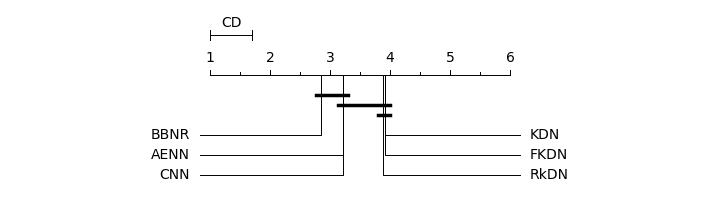

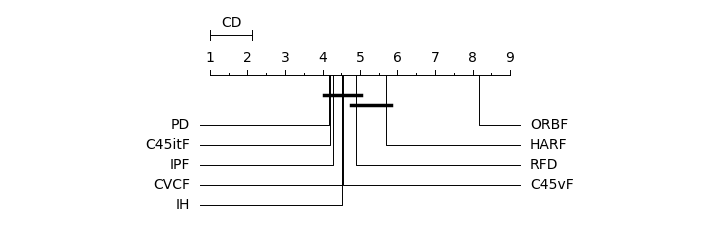

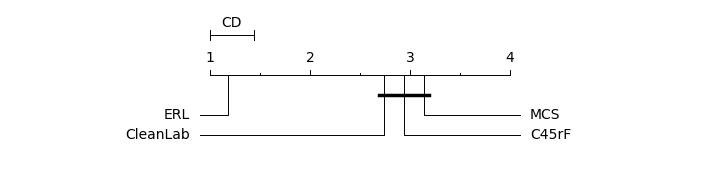

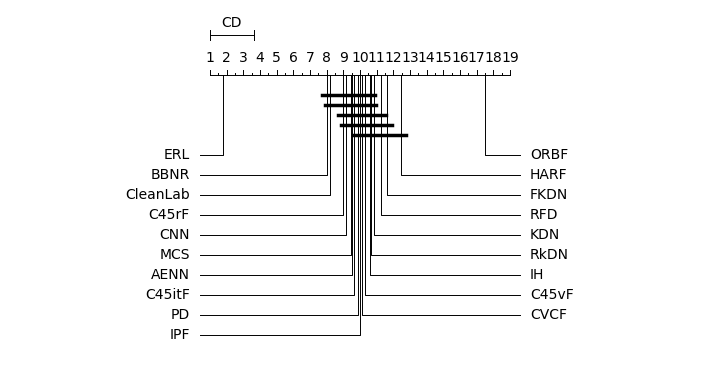

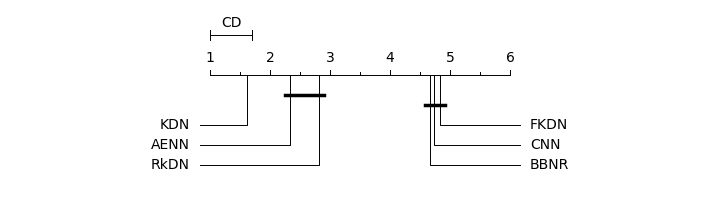

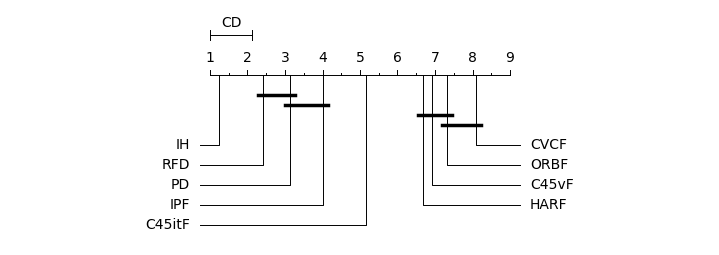

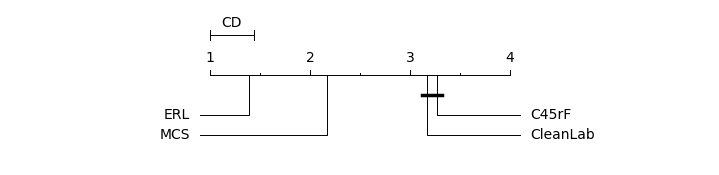

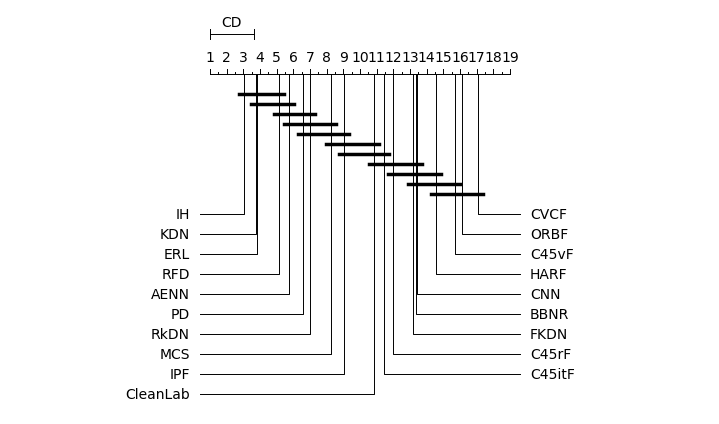

In [13]:
scores = ['Precision','Recall']
#fig, axs = plt.subplots(3,2,figsize=(16,4*len(score)))

for i, score in enumerate(scores):
    for j,group in enumerate(groups+['All']):
        if group=='All':
            df = dfs#[dfs['Group']  == group]
        else:
            df = dfs[dfs['Group']  == group]
        d = df.pivot_table(values=score, index=['NoiseType','NoiseLevel','Dataset'], columns='Model', aggfunc='mean')
       # d = d.dropna(axis = 1)

        d = d.rank(ascending = False, axis = 1).astype(int)

        names = d.columns.to_list()
        #= ['RF', 'NN', 'SVM','LR','XGBoost', 'KNN']
        #d.columns.to_list()
        avranks = d.mean()
        # First Friedman test (global)  H0: no difference, if rejected 
        # Nemenyi or Bonferroni-Dunn (one-sided, two sided): H0: no difference
        cd = Orange.evaluation.compute_CD(avranks, len(d), alpha='0.05', 
                                         # test="bonferroni-dunn"
                                         )
        print(cd)



        Orange.evaluation.graph_ranks(avranks, names, cd=cd, width=7
                                      , textspace=2,  fontsize = 2
                                      # cdmethod=0
                                     )
      #  group = 'All'
        name = 'figures/CD'+group+'_'+score+'.png'

        plt.savefig('figures/CD'+group+'_'+score+b+'.png',transparent=True,bbox_inches = 'tight', dpi = 300)


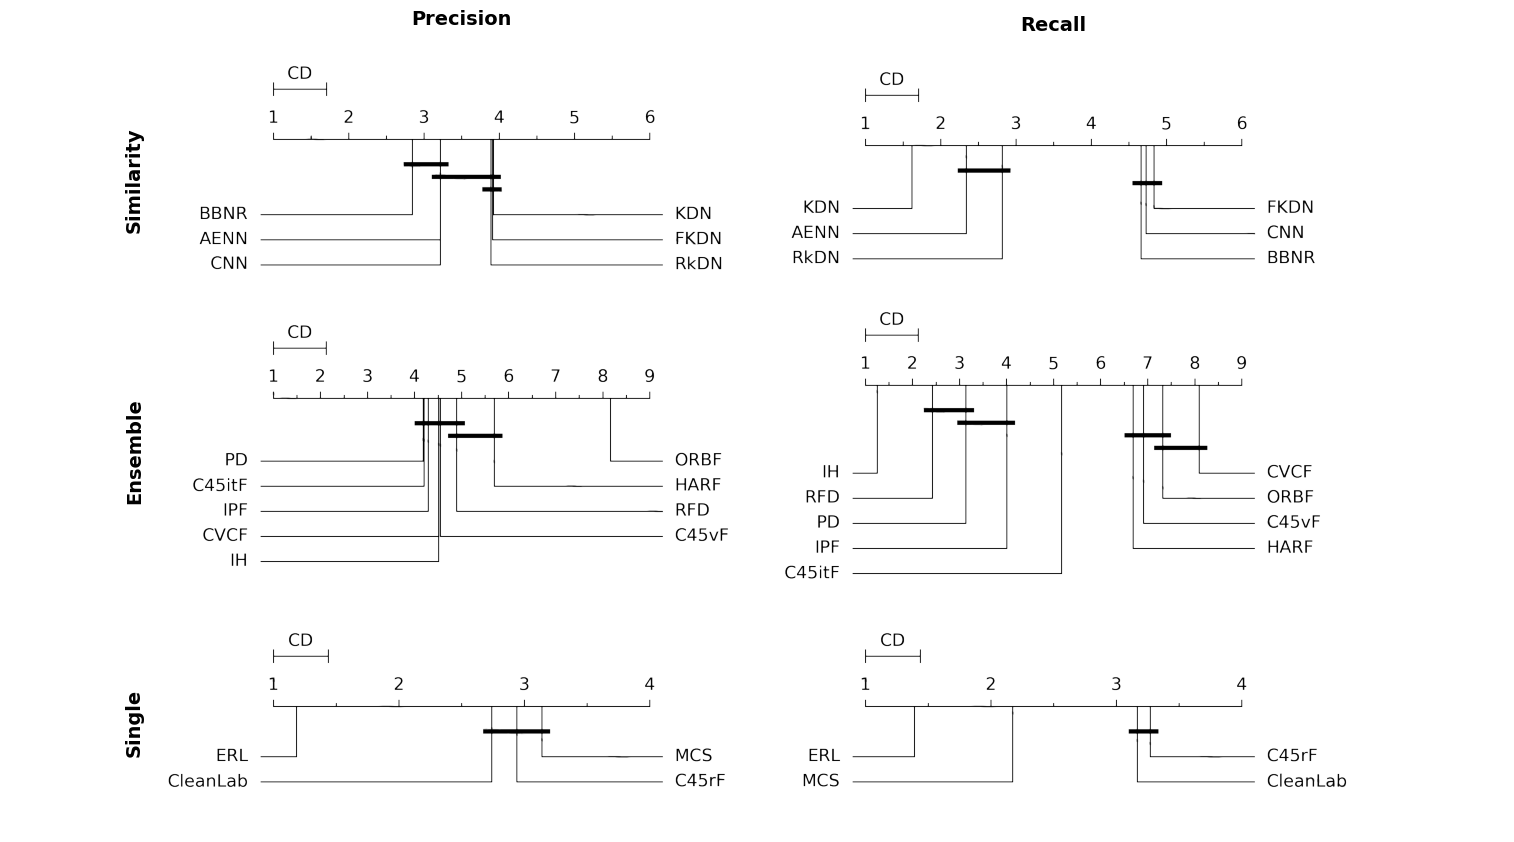

In [14]:
import pickle as pkl
fig, axs = plt.subplots(3,2,figsize=(8,2*len(score)))

for i, score in enumerate(scores):
    for j,group in enumerate(groups):
        

        name = 'figures/CD'+group+'_'+score+b+'.png'
        ax = plt.imread(name)
        axs[j,i].imshow(ax)
        axs[j,i].xaxis.set_visible(False) # same for y axis.
      #  axs[j,i].yaxis.set_visible(False) # same for y axis.
        fig.tight_layout(pad=-25.0)

        axs[j,i].set_frame_on(False)
        if j==0: 
            axs[j,i].set_title("{}".format(score), fontsize = 14, pad=15,weight='bold',style = 'normal',)
        if i==0:
            axs[j,i].set_ylabel(group,style = 'normal',
                                fontsize = 14,labelpad=-100 ,weight='bold'
                               )
        axs[j,i].set_yticks([]) 
plt.savefig('figures/CD'+b+'.png',transparent=False,bbox_inches = 'tight', dpi = 150)


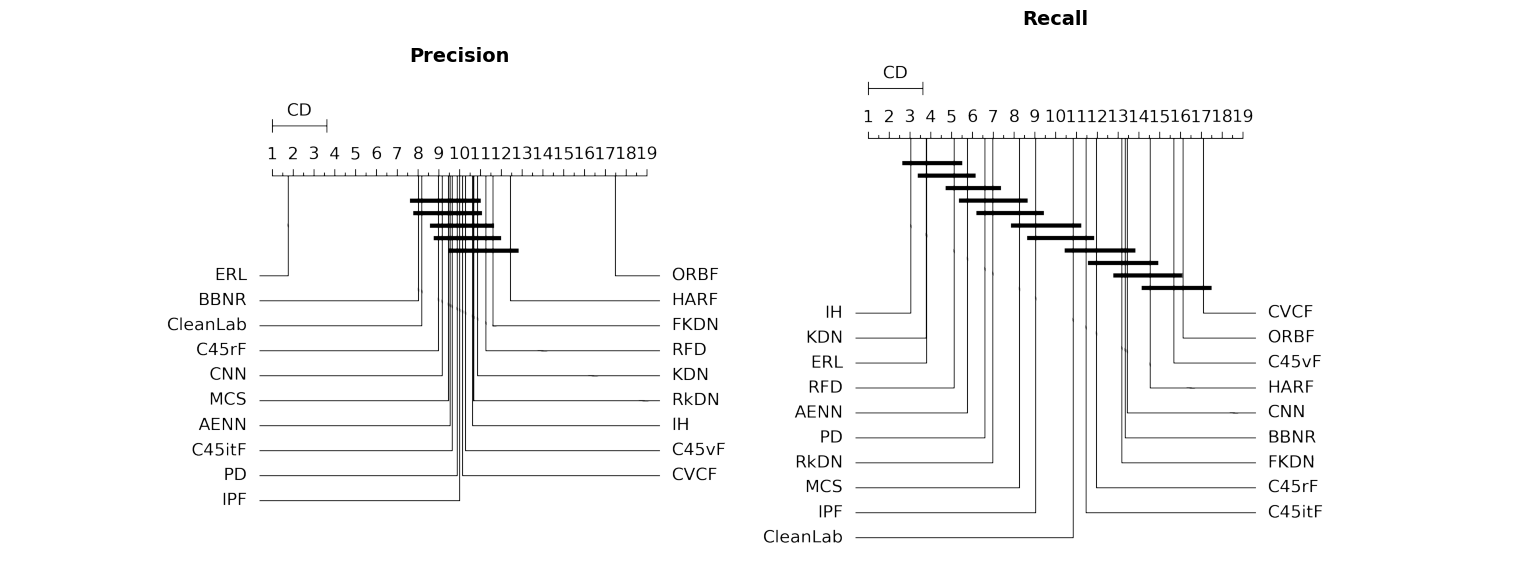

In [15]:
import pickle as pkl
fig, axs = plt.subplots(1,2,figsize=(8,2.5*len(score)))
group = 'All'
for i, score in enumerate(scores):        

        name = 'figures/CD'+group+'_'+score+b+'.png'
        ax = plt.imread(name)
        axs[i].imshow(ax)
#        axs[i].xaxis.set_visible(False) # same for y axis.
      #  axs[j,i].yaxis.set_visible(False) # same for y axis.
        fig.tight_layout(pad=-25.0)

        axs[i].set_frame_on(False)
       # if i==0: 
        axs[i].set_title("{}".format(score), fontsize = 14, pad=15,weight='bold',style = 'normal')
      
        axs[i].set_xticks([]) 
        axs[i].set_yticks([]) 

plt.savefig('figures/CD_All'+b+'.png',transparent=False,bbox_inches = 'tight', dpi = 150)


### Main Analysis (plots)

In [16]:
labels = {'NoiseLevel': 'Noise level',
         'DatasetSize' : 'Sample size'}
fs = 10

#### Figure 3. Precision, recall and F-score for different datasets over all parameters.

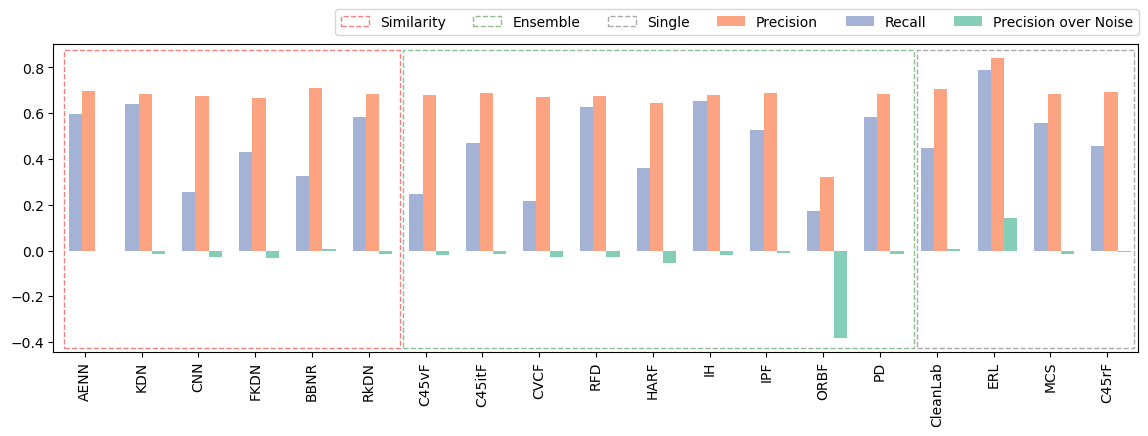

In [17]:

df =  dfs.groupby(['Model']).mean()[['Precision','Recall','F-score','Accuracy',pon]]#.dropna(how = 'all')


di = dict(dfs[['Model','Group']].value_counts().index)
di1 = {'Ensemble':1,'Similarity':0,'Single':2}



df['Group'] = df.index
df['Group'] = df['Group'].replace(di).replace(di1).astype(int)
df = df.sort_values('Group')
di2 = df['Group'].value_counts()
colors = []
for i in df['Group']:
    t = sns.color_palette("Set2", 8)[i]
    colors.append(t)
fig = plt.figure(figsize=(14,4
                         ))


colors = list(set(colors))
ax = fig.add_subplot(111)
indices = np.array(list(range(len(df))))
width = np.min(np.diff(indices))/3 -0.1

# matplotlib 3.0 you have to use align

ax.bar(indices+0.1,df['Precision'],width,align='edge',
       label = 'Precision',color = colors[1]
       ,alpha = 0.8 )



ax.bar(indices-width+0.1,df['Recall'],width,align='edge',
       label = 'Recall' ,alpha = 0.8, color = colors[2]
      )

ax.bar(indices+width+0.1,df[pon],width,align='edge',alpha = 0.8,
       label = pon,color = colors[0]
      )


plt.xticks(indices+0.15, df.index.to_list(), fontsize = fs,rotation=90)
plt.yticks(fontsize = fs)



ax.add_patch(plt.Rectangle((0.01, 0.01), .309, 0.97, ls="--", ec="lightcoral", fc="none", 
    transform=ax.transAxes, label = 'Similarity'))

ax.add_patch(plt.Rectangle((0.322, 0.01), .471, 0.97, ls="--", ec="darkseagreen", 
                           fc="none",
                           transform=ax.transAxes, label = 'Ensemble'))

ax.add_patch(plt.Rectangle((0.796, 0.01), .20, 0.97, ls="--", ec="darkgrey", 
                           fc="none",
                           transform=ax.transAxes, label = 'Single'))

#fig.legend(#)
plt.legend(ncol = 6, fontsize = fs, loc='center', bbox_to_anchor=(0.63, 1.07))

plt.xlim([-0.4,len(indices)-0.3])
    

name = 'BarPlotAll'+b+'.png'    
plt.savefig('figures/'+ name,transparent=False,bbox_inches = 'tight', dpi = 150)

plt.show()

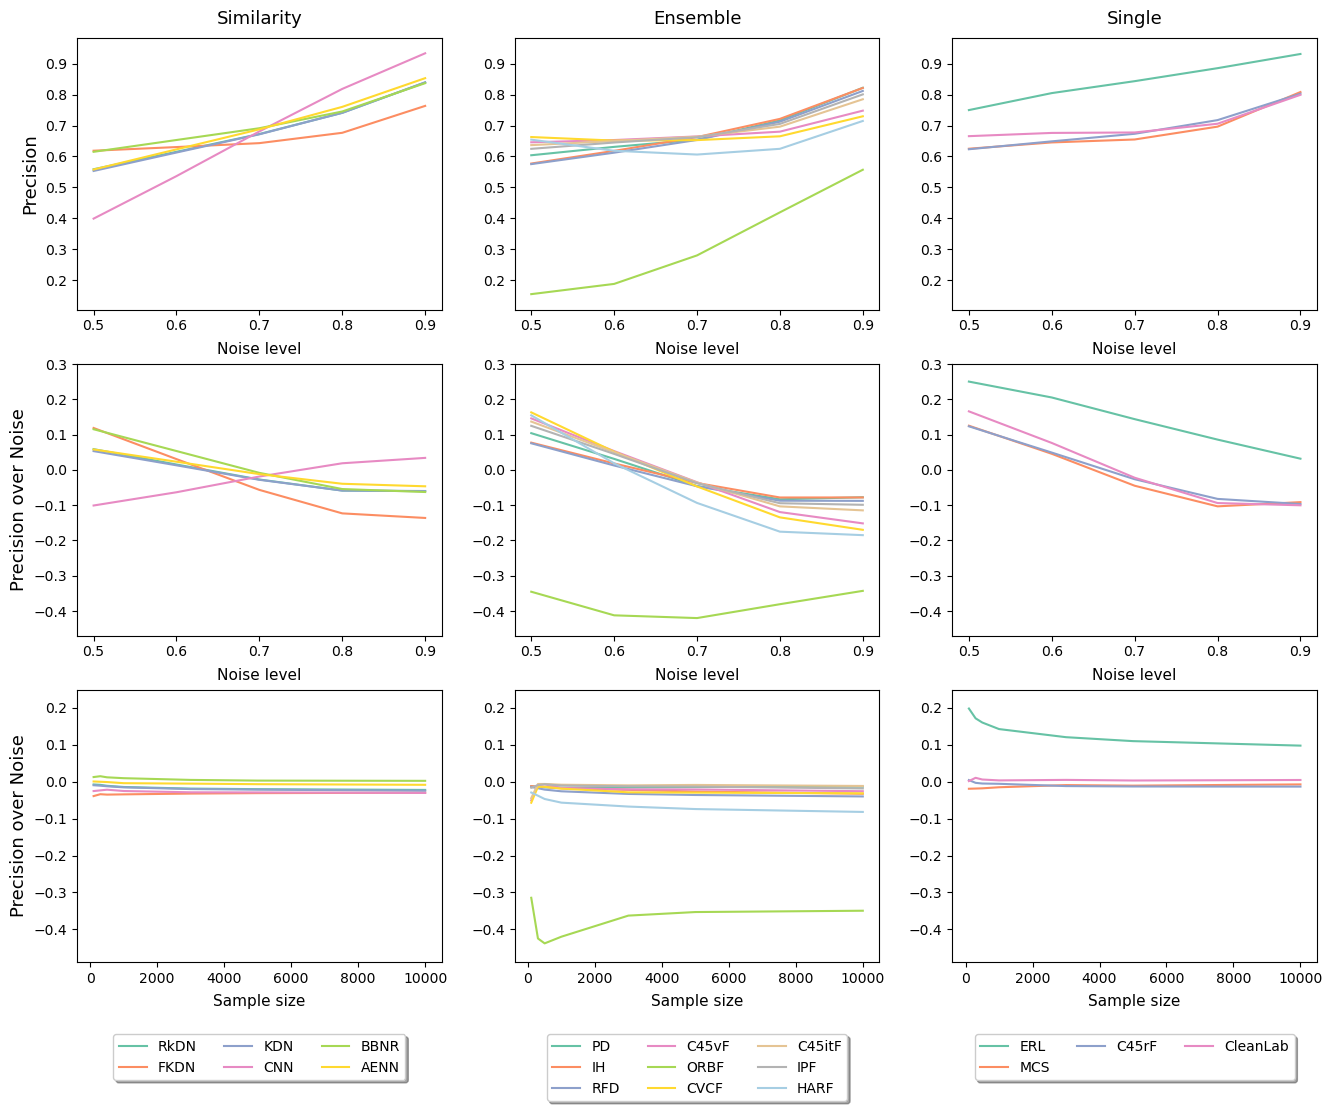

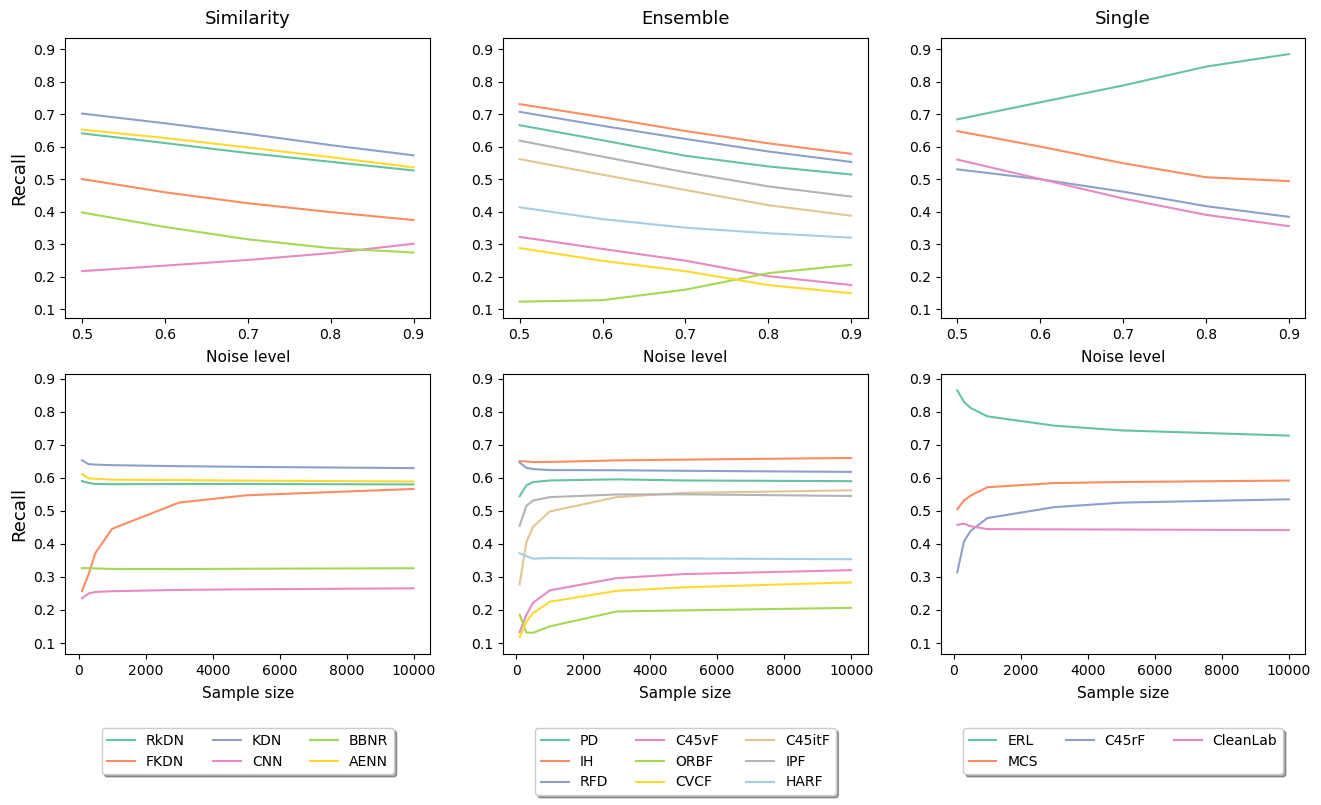

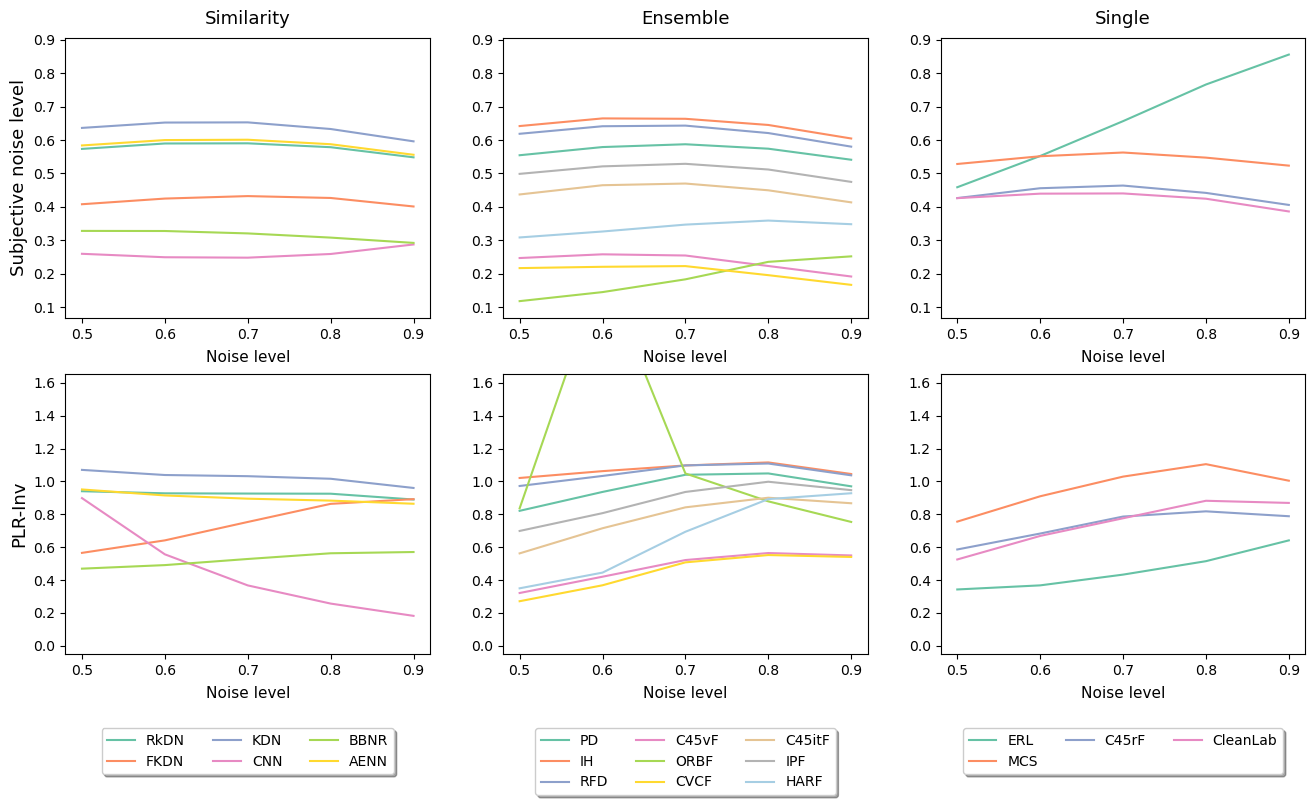

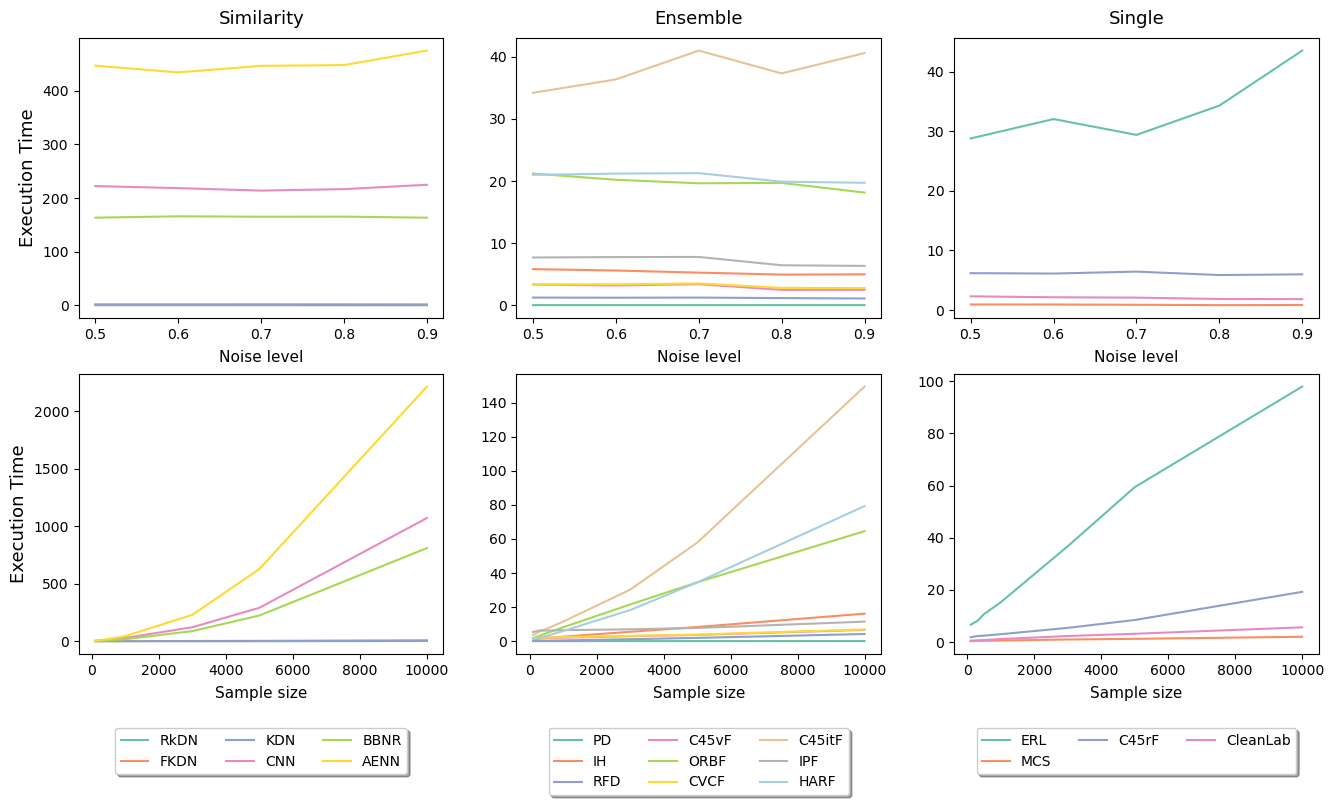

In [18]:
## Performance wrt to particular model 


allScores = dfs
di = {
    'PrecisionOverNoise':[['Precision', pon, pon], ['NoiseLevel','NoiseLevel','DatasetSize'], True], #Figure 7
     'RecallOverNoise':[['Recall', 'Recall'], ['NoiseLevel','DatasetSize'], True], # Figure 8
     'CostOfTP' : [[retrieved,'PLR-Inv' ], ['NoiseLevel','NoiseLevel'], True], # Figure 10
      'ExecutionTime' : [['Execution Time','Execution Time'],['NoiseLevel','DatasetSize'], False],
 #   'CostComparison' : [[retrieved, 'F-score','F-score-mod', 'Cost','Cost-mod','PLR','PLR-Inv'], ['NoiseLevel']*7, True]
     
     }



fontsize = 10

for key in di.keys():

    li = di[key][0]
    variables = di[key][1]
    fig, axs = plt.subplots(len(li),3,figsize=(16,4*len(li)))

    for j,Score in enumerate(li):

        scores = allScores
        variable = variables[j]
        label = labels[variable]
        lim = scores.groupby(['Model', variable]).mean()[Score]
        if (key=='CostOfTP')& (Score=='PLR-Inv'):
            lim = pd.Series([0,scores.groupby(['Model', variable]).mean()[Score].sort_values(ascending = False)[3]+0.5])
        applyLim = di[key][2]
        for i,group in enumerate(groups):  
                models = mod[mod['Group']==group]['Abbreviation']

                for model in models[:]:
                    table_ = scores[scores['Model'] == model]
                   # print(model,len(table_))


                    if len(table_) > 0:

                        table = pd.DataFrame(table_.groupby(variable).mean()).reset_index()
                        table_ = table.sort_values([variable])

                        axs[j,i].plot(table[variable],table[Score].astype(float),  label = model)
                        if j==len(li)-1: 
                            axs[j,i].legend(loc='upper center', bbox_to_anchor=(0.5, -0.24),
                  fancybox=True, shadow=True, ncol=3)
                        axs[j,i].set_xlabel(label,fontsize = 11, labelpad=6 )

                        if j==0: 
                            axs[j,i].set_title("{}".format(group), fontsize = 13, pad=10)
                        if i==0:
                            axs[j,i].set_ylabel(Score,fontsize = 13 )
                        if applyLim:
                            axs[j,i].set_ylim(lim.min()-0.05,lim.max()+0.05)
    name = key+'Noise04.png'
    plt.savefig('figures/'+name,transparent=False,bbox_inches = 'tight', dpi = 150)


#### Save dataset desciptions into a file


In [19]:
# dont run
#datasets = ["RNA0", "RNA1", "RNA2"]

#for dataset in datasets[:]:

#df = pd.read_csv('datasets/'+dataset+'.csv.gz',sep = '\t', compression = 'zip')
#    print(dataset, df.shape)
#    print(df.iloc[:,-1].value_counts(normalize = True, sort = False).round(2).to_dict())

In [20]:
fs

10

#### Model performance on different datasets (vertical plots)

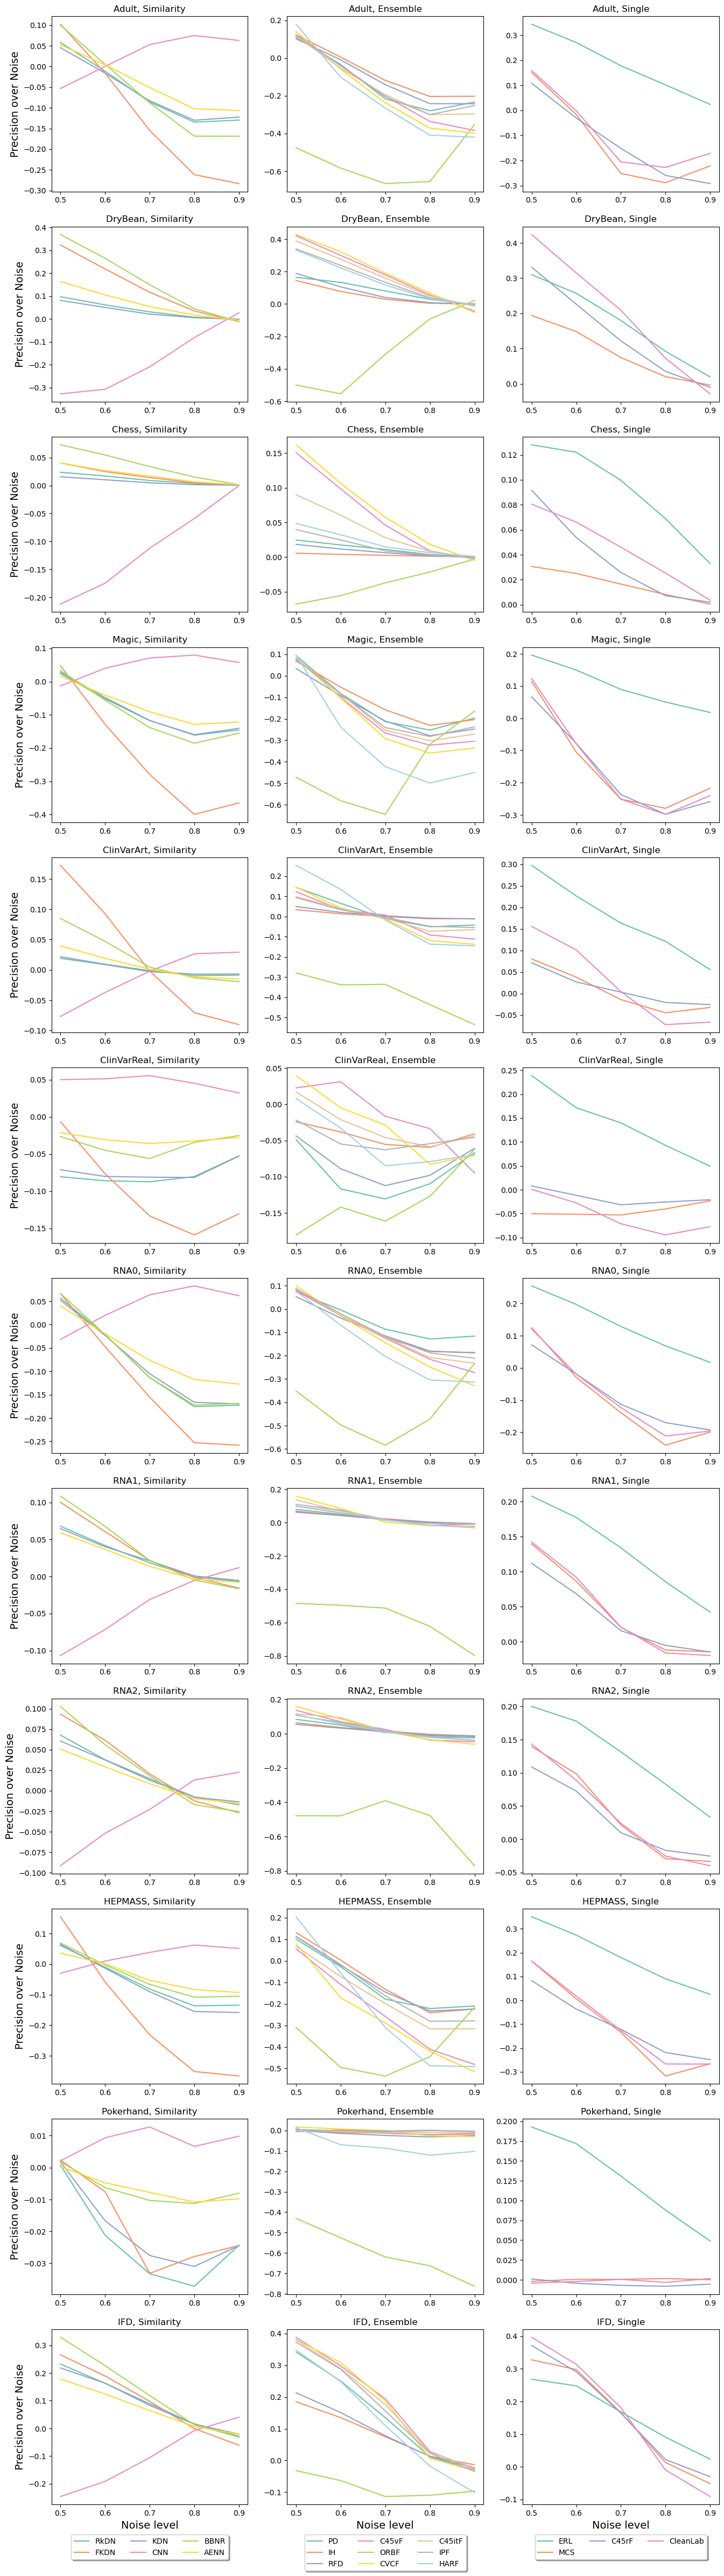

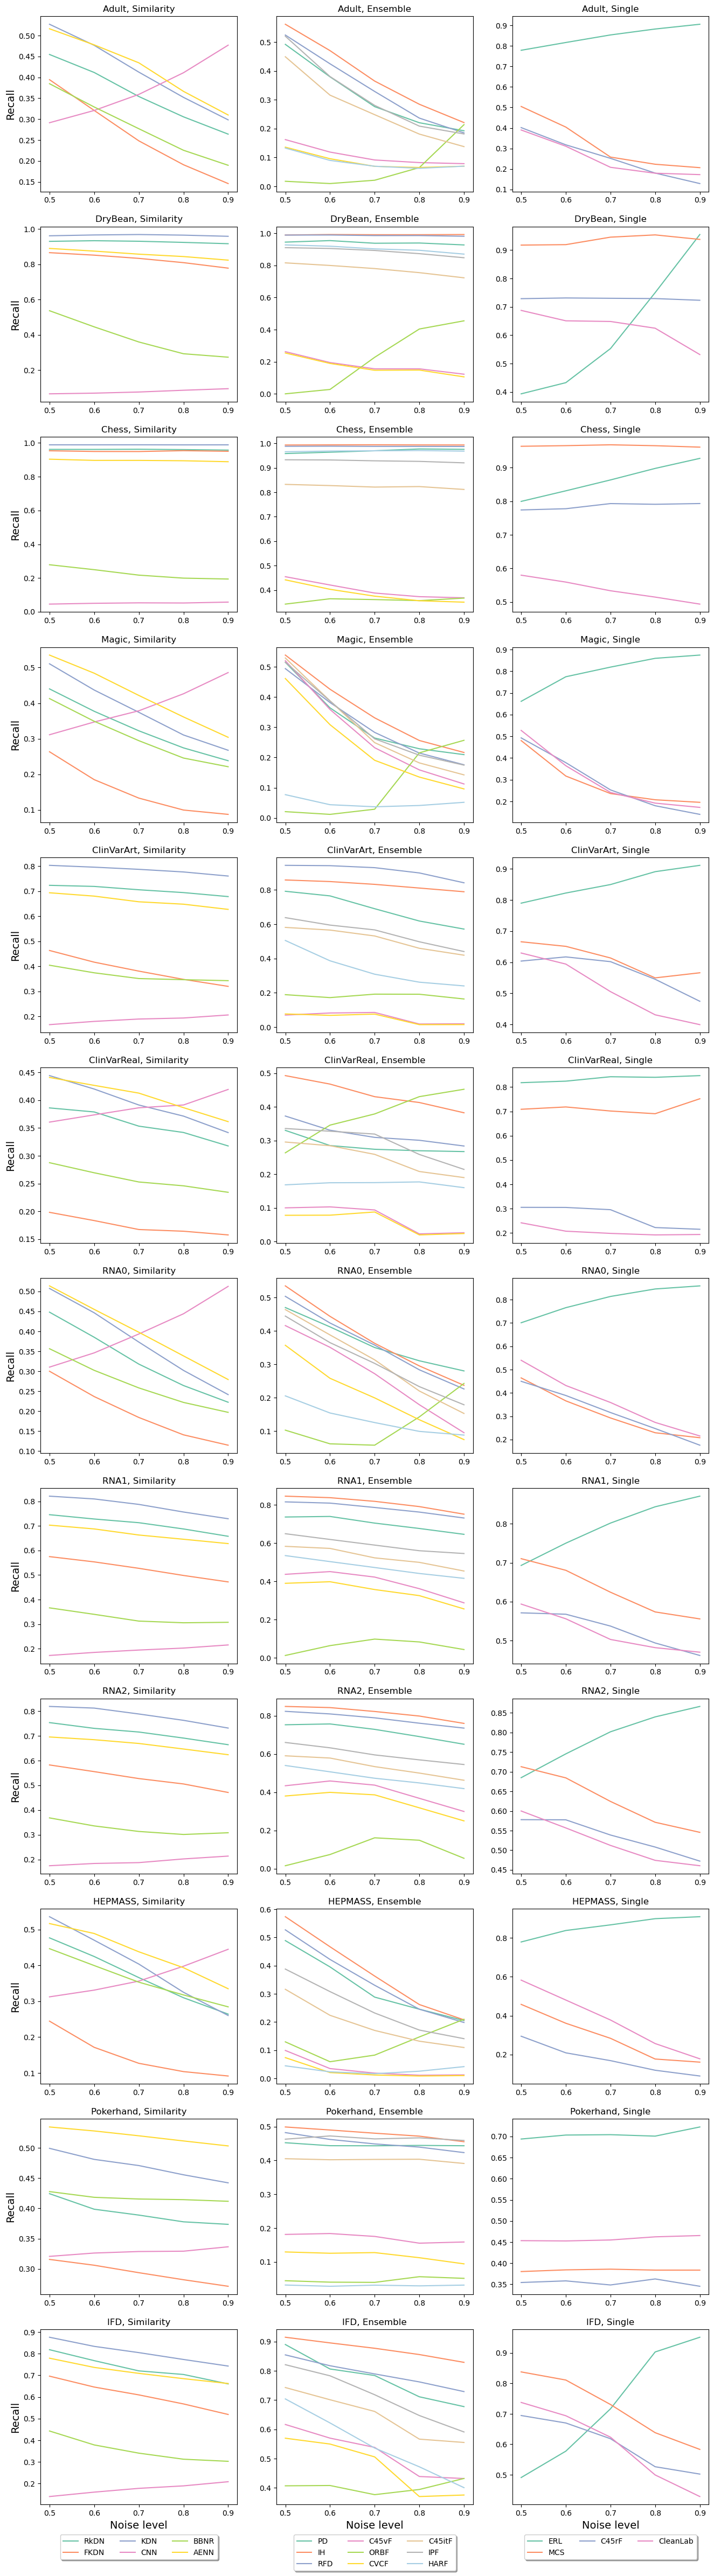

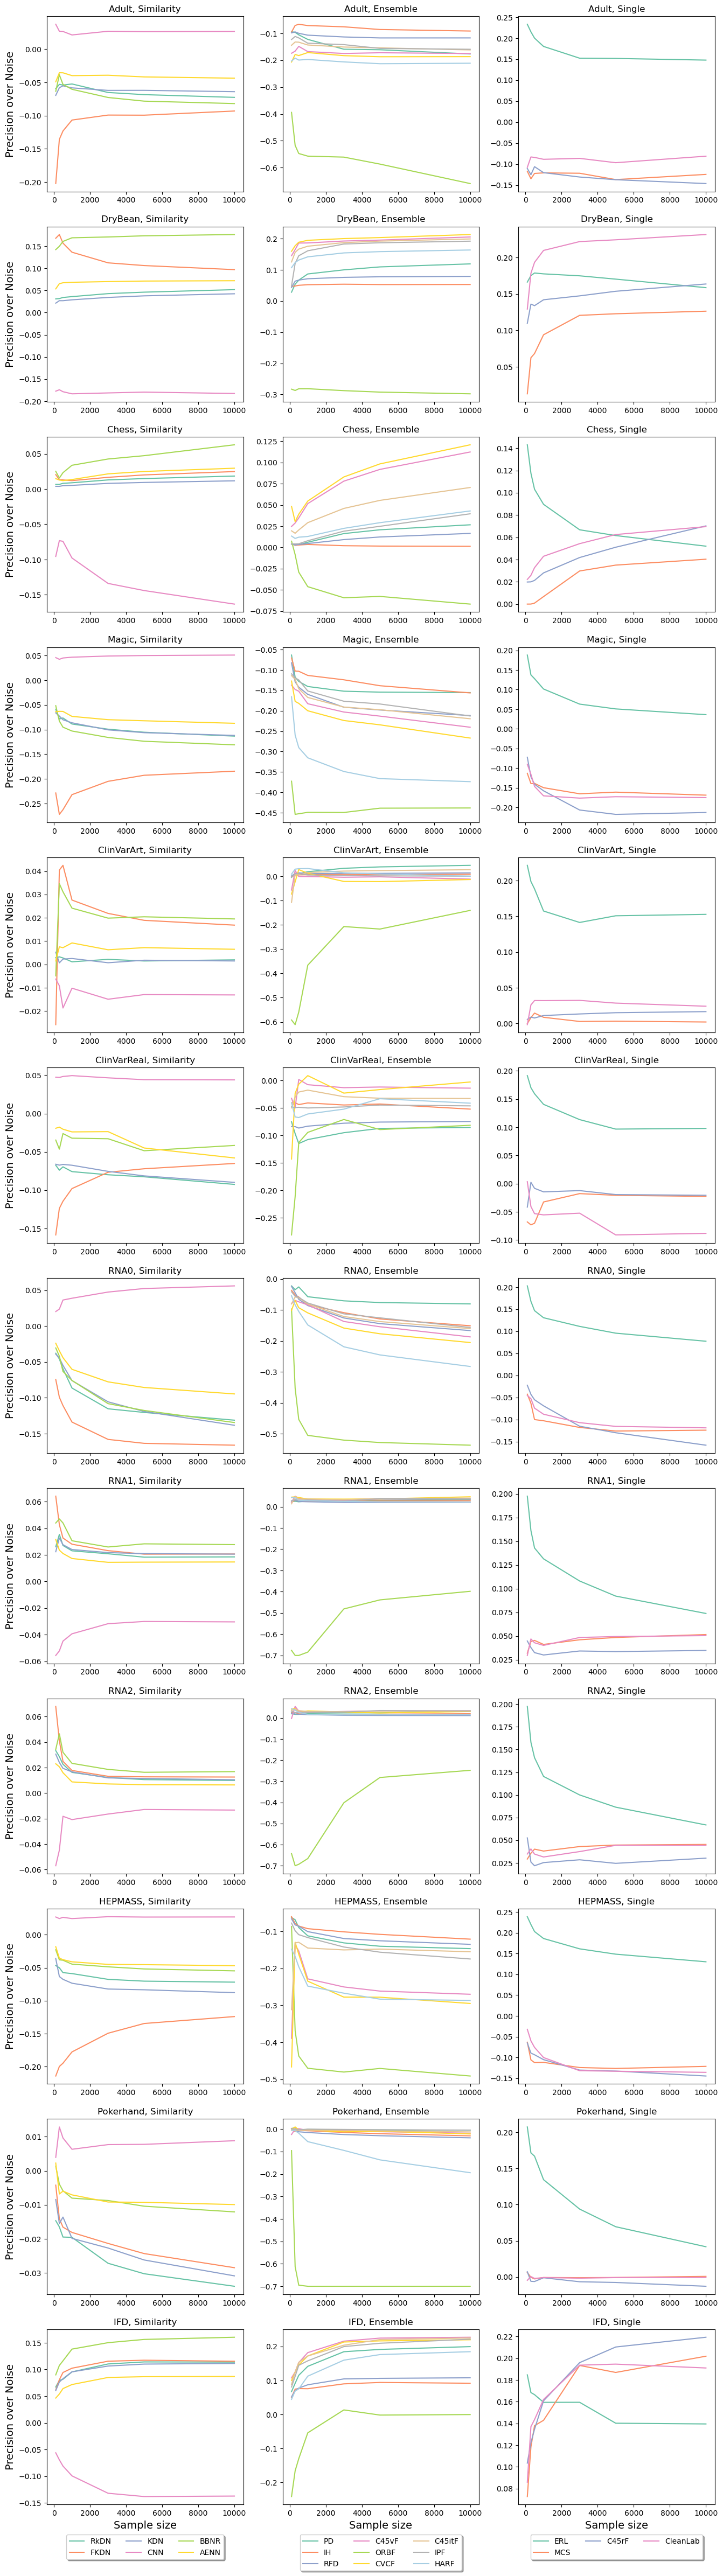

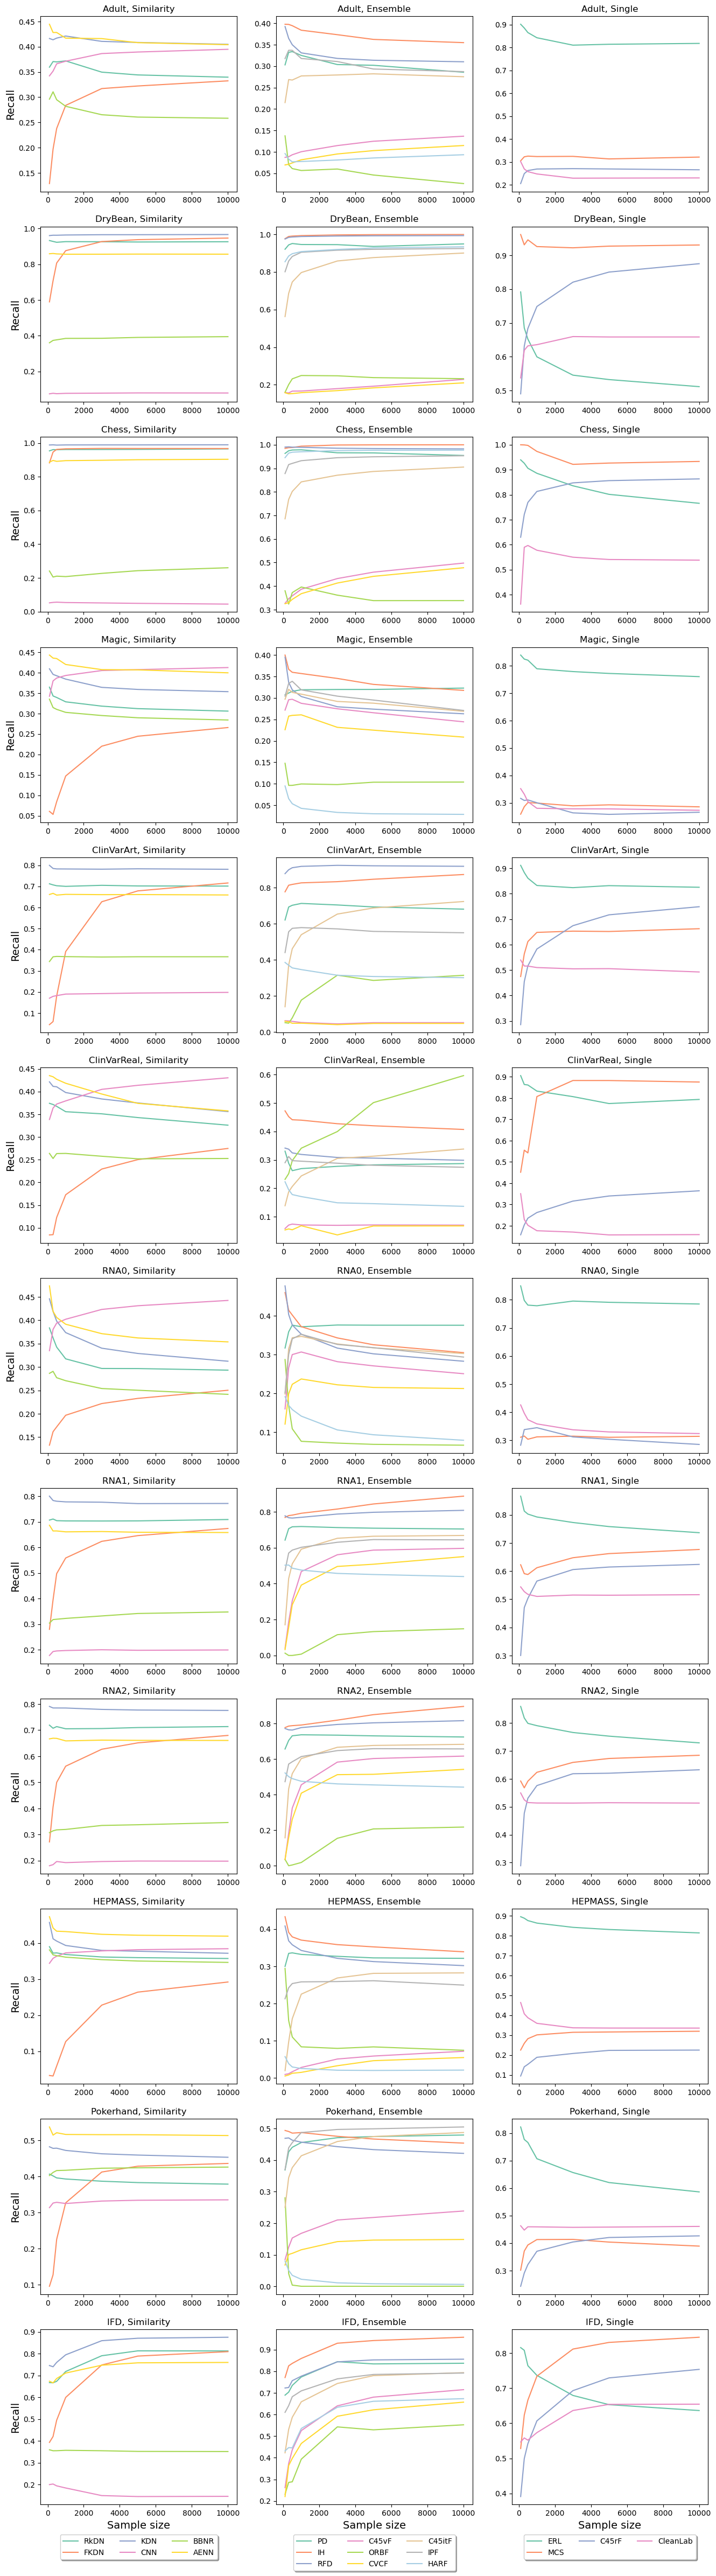

In [21]:

allScores = dfs



di = {'PonOverNoisePerDataset' : [[pon],['NoiseLevel']],
      'RecallOverNoisePerDataset' : [['Recall'],['NoiseLevel']],
      'PonOverDSPerDataset' : [[pon],['DatasetSize']],
      'RecallOverDSPerDataset' : [['Recall'],['DatasetSize']],

    
}

n = len(datasets)

for key in di.keys():
    Score = di[key][0][0]
    variable = di[key][1][0]
    label = labels[variable]
    fig, axs = plt.subplots(n,3,figsize=(16,5*n))

    for j,Dataset in enumerate(datasets[:n]):

        scores = allScores[((allScores['Dataset'].str.contains(Dataset)))]
     #   print(len(scores))

        for i,group in enumerate(groups):  
                #print(i)
                models = mod[mod['Group']==group]['Abbreviation']
                    #plt.figure(figsize=(8,5))
                for model in models[:]:

                    table_ = scores[scores['Model'] == model]

                    if len(table_) > 0:
                        table_ = table_.sort_values([variable])
                        table = pd.DataFrame(table_.groupby(variable).mean()).reset_index()
                        axs[j,i].plot(table[variable],table[Score].astype(float),  label = model)

                        if j==n-1: 
                             axs[j,i].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
                  fancybox=True, shadow=True, ncol=3)

                        axs[j,i].set_title("{}, {}".format(Dataset, group), fontsize = 12 )
                        if j==n-1: 
                            axs[j,i].set_xlabel(label,fontsize = 14 )
                        if i==0:
                            axs[j,i].set_ylabel(Score,fontsize = 14 )
                        #plt.savefig('figures/'+Dataset+Score+noiseType+'.png',transparent=True)
    plt.savefig('figures/'+Score+'_'+variable+'Noise04.png',transparent=False,bbox_inches = 'tight', dpi = 150)


#### Correlation score scores for cost of filtering

In [22]:
a = dfs[['Precision',pon,'Recall','F-score', 'F-score-mod','NoiseLevel','NoiseType','DatasetSize','Subjective noise level', 
         'Cost','Cost-mod','PLR','PLR-Inv'  ]]

corr = a.corr().round(3)
corr.round(3)

corr.columns = corr.columns.str.replace(pon,'PON').str.replace( 'Subjective noise level', 'SNR')
corr.index = corr.index.str.replace(pon,'PON').str.replace( 'Subjective noise level', 'SNR')

corr

Precision    PON  Recall  F-score  F-score-mod  NoiseLevel  \
Precision        1.000  0.749   0.471    0.627        0.428       0.368   
PON              0.749  1.000   0.564    0.643        0.724      -0.341   
Recall           0.471  0.564   1.000    0.960        0.910      -0.124   
F-score          0.627  0.643   0.960    1.000        0.895      -0.012   
F-score-mod      0.428  0.724   0.910    0.895        1.000      -0.409   
NoiseLevel       0.368 -0.341  -0.124   -0.012       -0.409       1.000   
DatasetSize     -0.016 -0.016   0.058    0.052        0.050      -0.000   
SNR              0.388  0.383   0.949    0.900        0.778       0.013   
Cost            -0.537 -0.698  -0.382   -0.440       -0.475       0.187   
Cost-mod        -0.689 -0.496  -0.301   -0.402       -0.275      -0.222   
PLR              0.140  0.209  -0.056   -0.056       -0.014      -0.081   
PLR-Inv         -0.503 -0.576   0.080   -0.025       -0.064       0.084   

             DatasetSize    SNR   Cost  Cost-mod    PLR  PLR-Inv  
Precision         -0.016  0.388 -0.537    -0.689  0.140   -0.503  
PON               -0.016  0.383 -0.698    -0.496  0.209   -0.576  
Recall             0.058  0.949 -0.382    -0.301 -0.056    0.080  
F-score            0.052  0.900 -0.440    -0.402 -0.056   -0.025  
F-score-mod        0.050  0.778 -0.475    -0.275 -0.014   -0.064  
NoiseLevel        -0.000  0.013  0.187    -0.222 -0.081    0.084  
DatasetSize        1.000  0.066  0.042     0.038  0.029    0.083  
SNR                0.066  1.000 -0.245    -0.216 -0.136    0.301  
Cost               0.042 -0.245  1.000     0.905 -0.091    0.593  
Cost-mod           0.038 -0.216  0.905     1.000 -0.064    0.565  
PLR                0.029 -0.136 -0.091    -0.064  1.000   -0.184  
PLR-Inv            0.083  0.301  0.593     0.565 -0.184    1.000

In [23]:
#corr.to_excel('figures/corr_table.xlsx')

#### Comparison of symmetric, asymmetric noise and real aggregated over datasets 

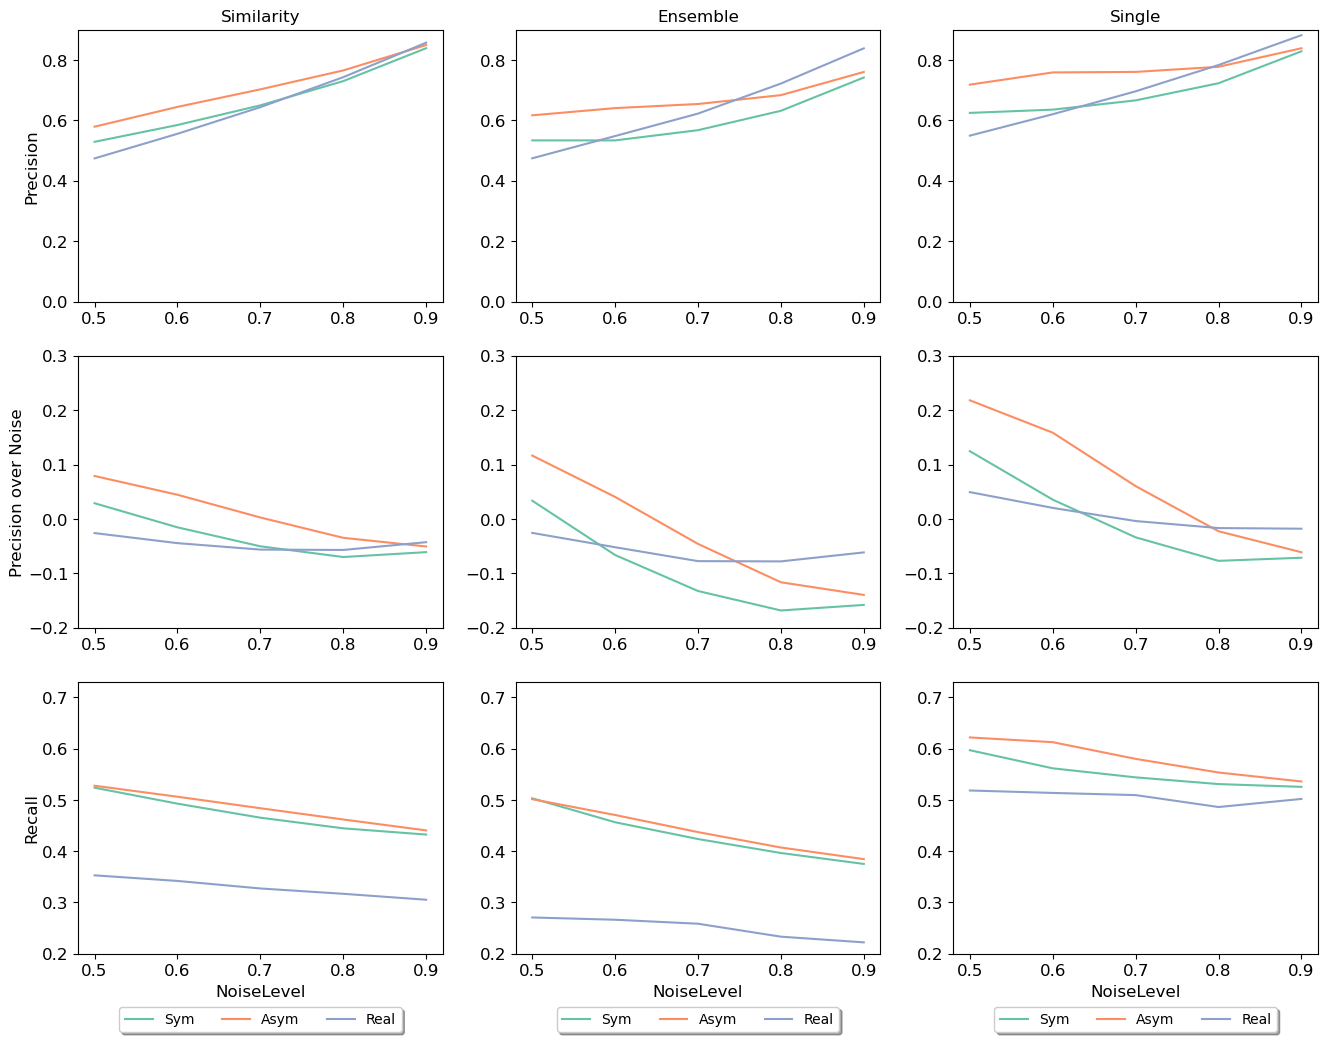

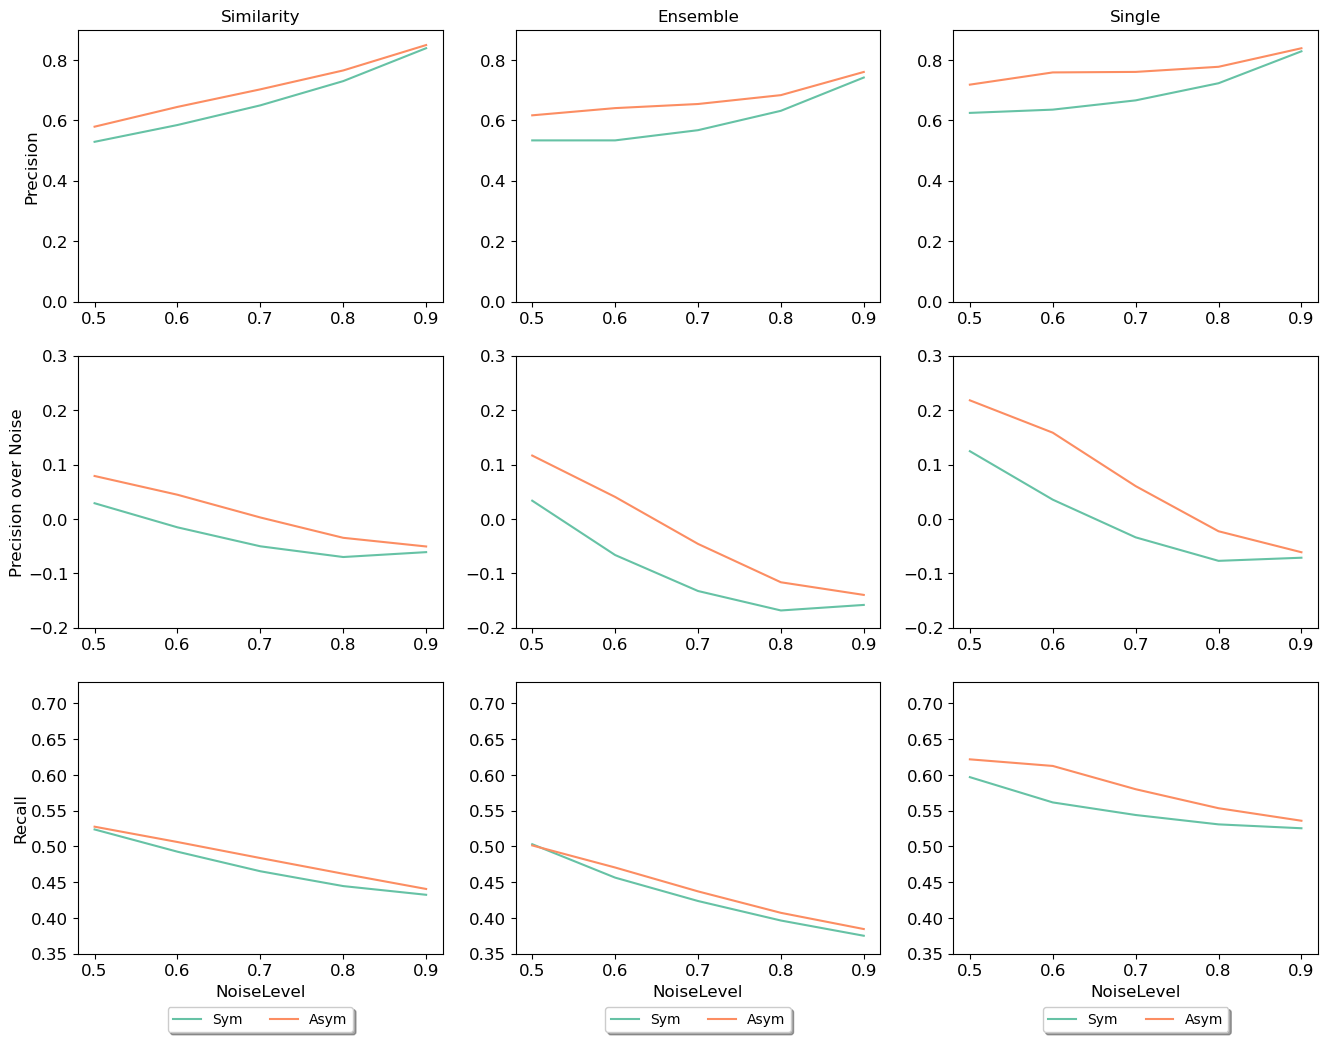

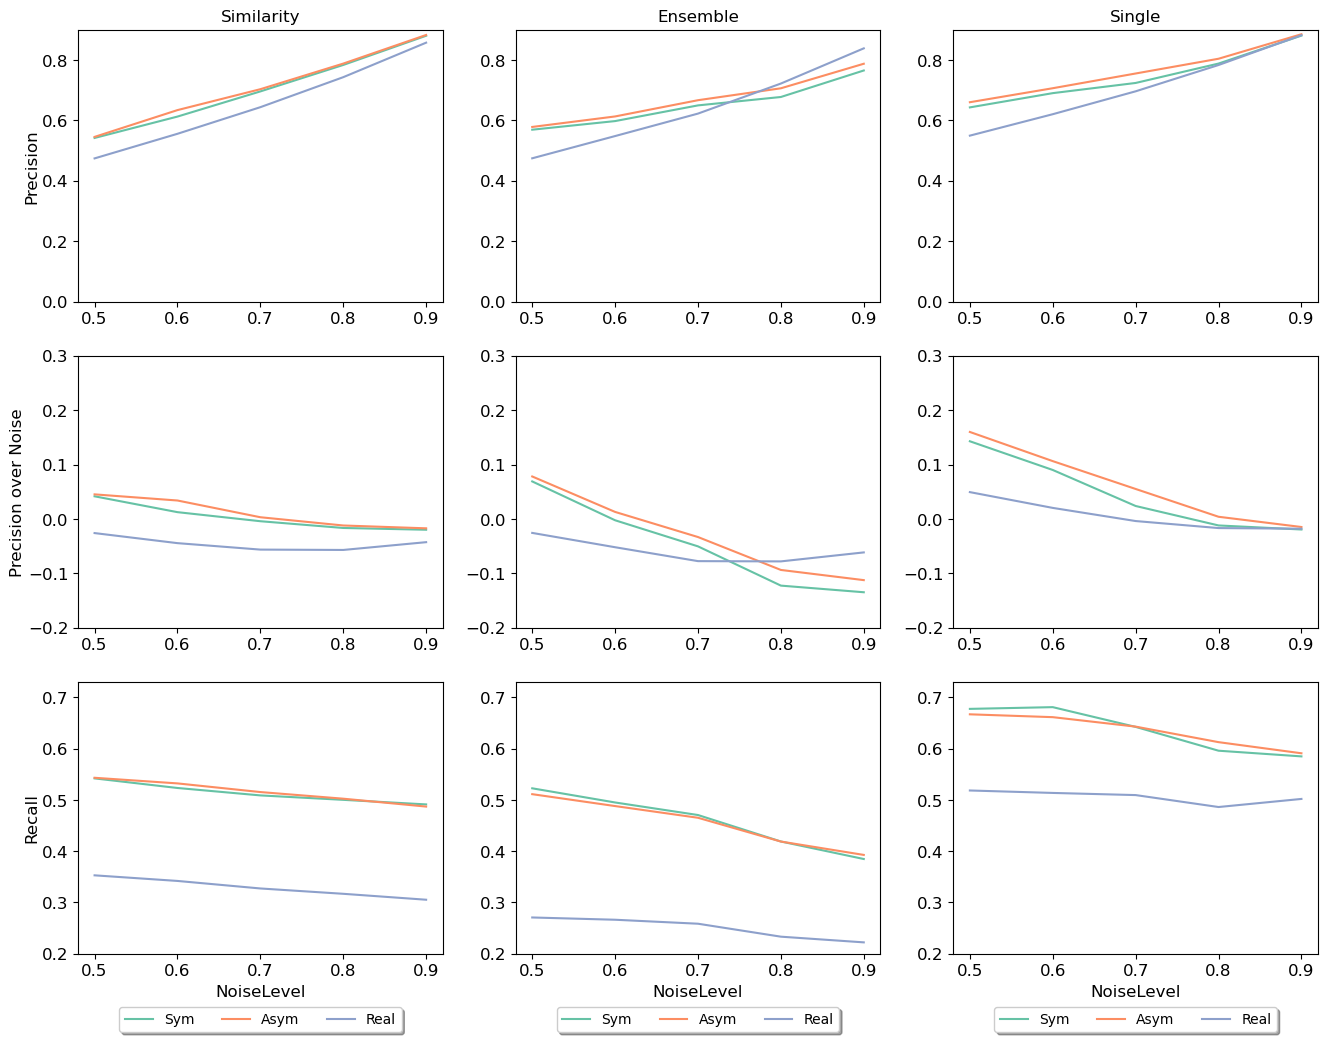

In [24]:
### Performance wrt dataset size and noise type

allScores = dfs
clinVarScores = allScores[allScores['Dataset'].isin(['ClinVarReal','ClinVarArt'])]

fontsize = 10

allNoiseTypes = ["Sym","Asym", "Real"]
twoNoiseTypes = ["Sym","Asym"]


NoiseTypes = allNoiseTypes
n = len(NoiseTypes)


ClinVarLim = [[0,0.9],[-0.2,0.3],[0.2,0.73]]
allLim = [[0,0.9],[-0.2,0.3],[0.35,0.73]]


scores, variabels = [['Precision',pon, 'Recall'],['NoiseLevel','NoiseLevel','NoiseLevel']]

di = {'NoiseTypeAll': [allScores,allNoiseTypes,ClinVarLim,scores, variabels],
      'NoiseTypeAllW' : [allScores,twoNoiseTypes,allLim,scores, variabels],
      'NoiseTypeClinVar' :[clinVarScores,allNoiseTypes,ClinVarLim, scores, variabels]}


for key in di.keys():
    li = di[key][3]

    fig, axs = plt.subplots(len(li),3,figsize=(16,4*len(li)))
    for j,Score in enumerate(li):

        scores_raw = di[key][0]
        NoiseTypes = di[key][1]
        lim = di[key][2]
        variable = di[key][4][j]
        for noiseType in NoiseTypes:
            scores_ =scores_raw[scores_raw['NoiseType'] == noiseType]

          #  print(len(scores_))

            for i,group in enumerate(groups):  
                models = mod[mod['Group']==group]['Abbreviation']
                scores = scores_[scores_['Model'].isin(models)]

                table = scores.groupby(variable).mean().reset_index()

                if len(table) > 0:

                    if i==0:
                        axs[j,i].set_ylabel(Score,fontsize = fs+2, labelpad = 2 )

                    axs[j,i].plot(table[variable],table[Score].astype(float),  label = noiseType)
                    axs[j,i].tick_params(axis='both', which='major', labelsize=fs +2)
                    if j==0: 
                        axs[j,i].set_title("{}".format(group), fontsize = fs+2 )

                    if j==len(li)-1: 
                        axs[j,i].legend(loc='upper center', bbox_to_anchor=(0.5, -0.17),
              fancybox=True, shadow=True, ncol=3,fontsize = fs )
                        axs[j,i].set_xlabel(variable,fontsize = fs +2 )

                    axs[j,i].set_ylim(lim[j])

    name = key+ b + '.png'
    plt.savefig('figures/' + name,transparent=False,bbox_inches = 'tight', dpi = 150)


#### Pivot table (heatmap) of  model performance vs. sample

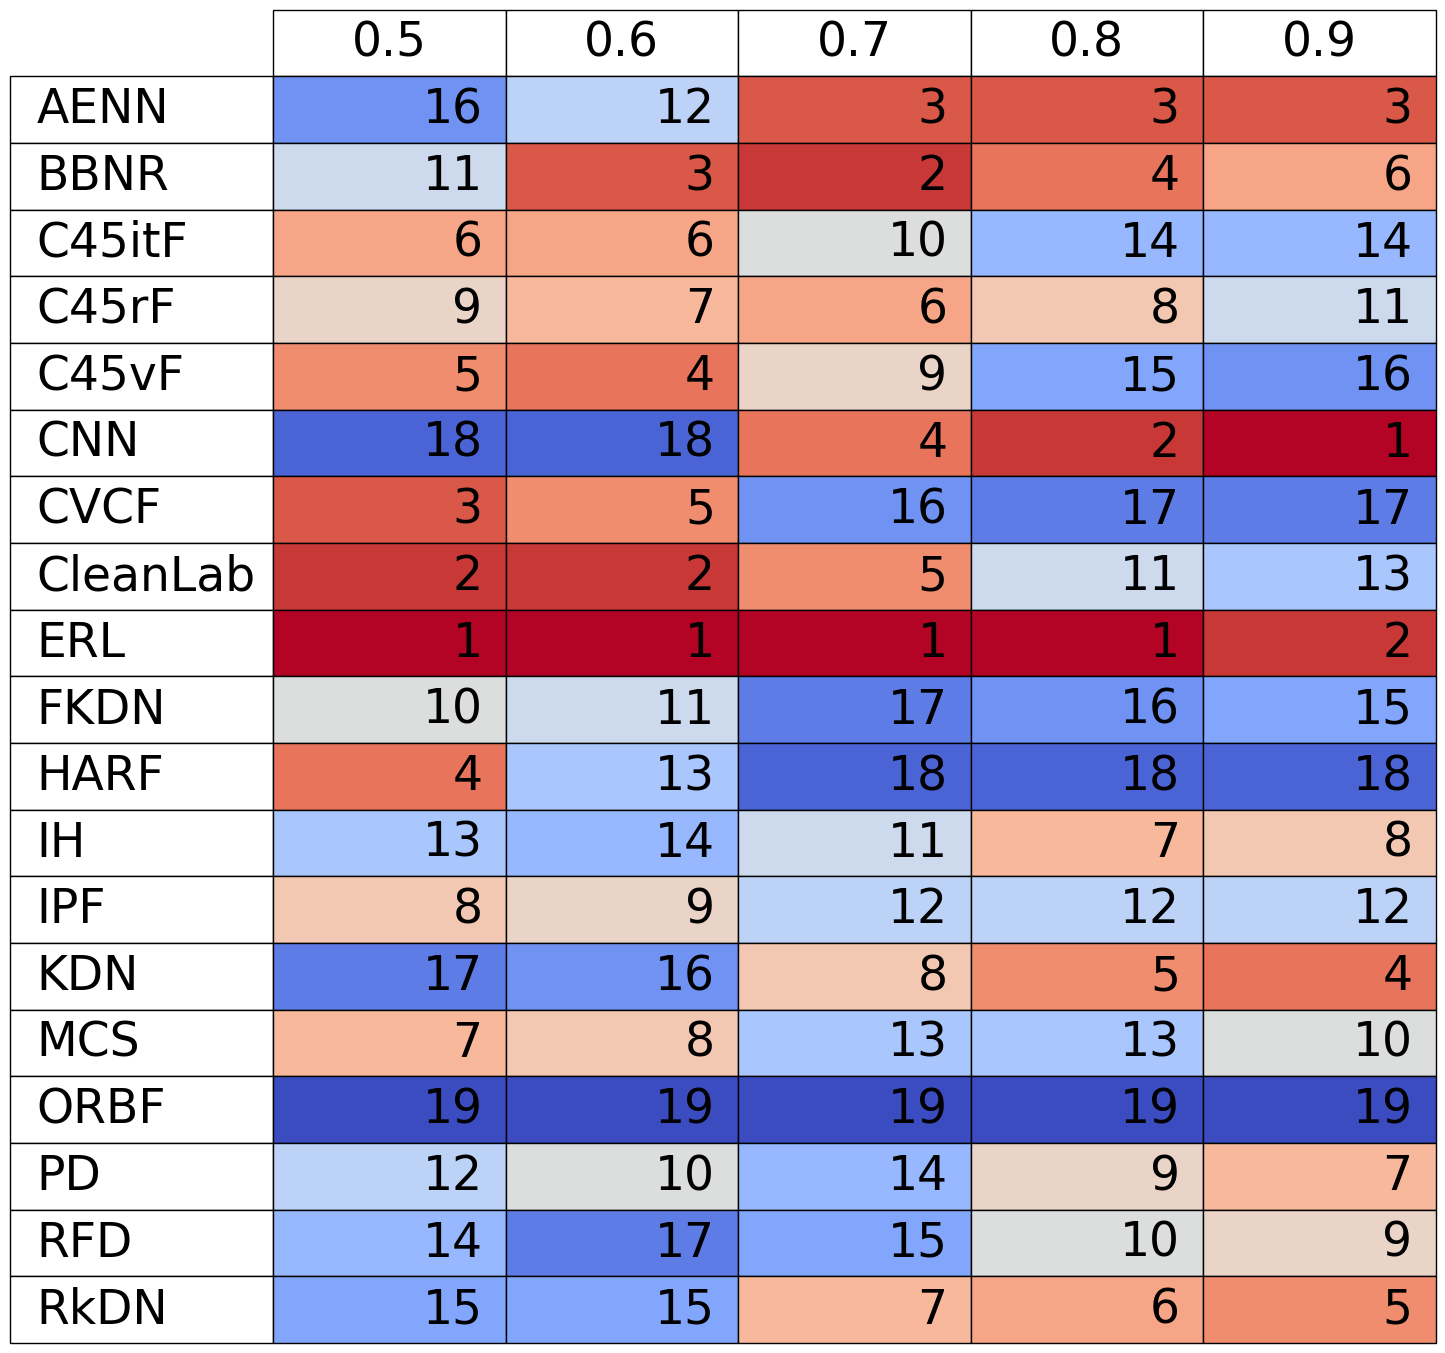

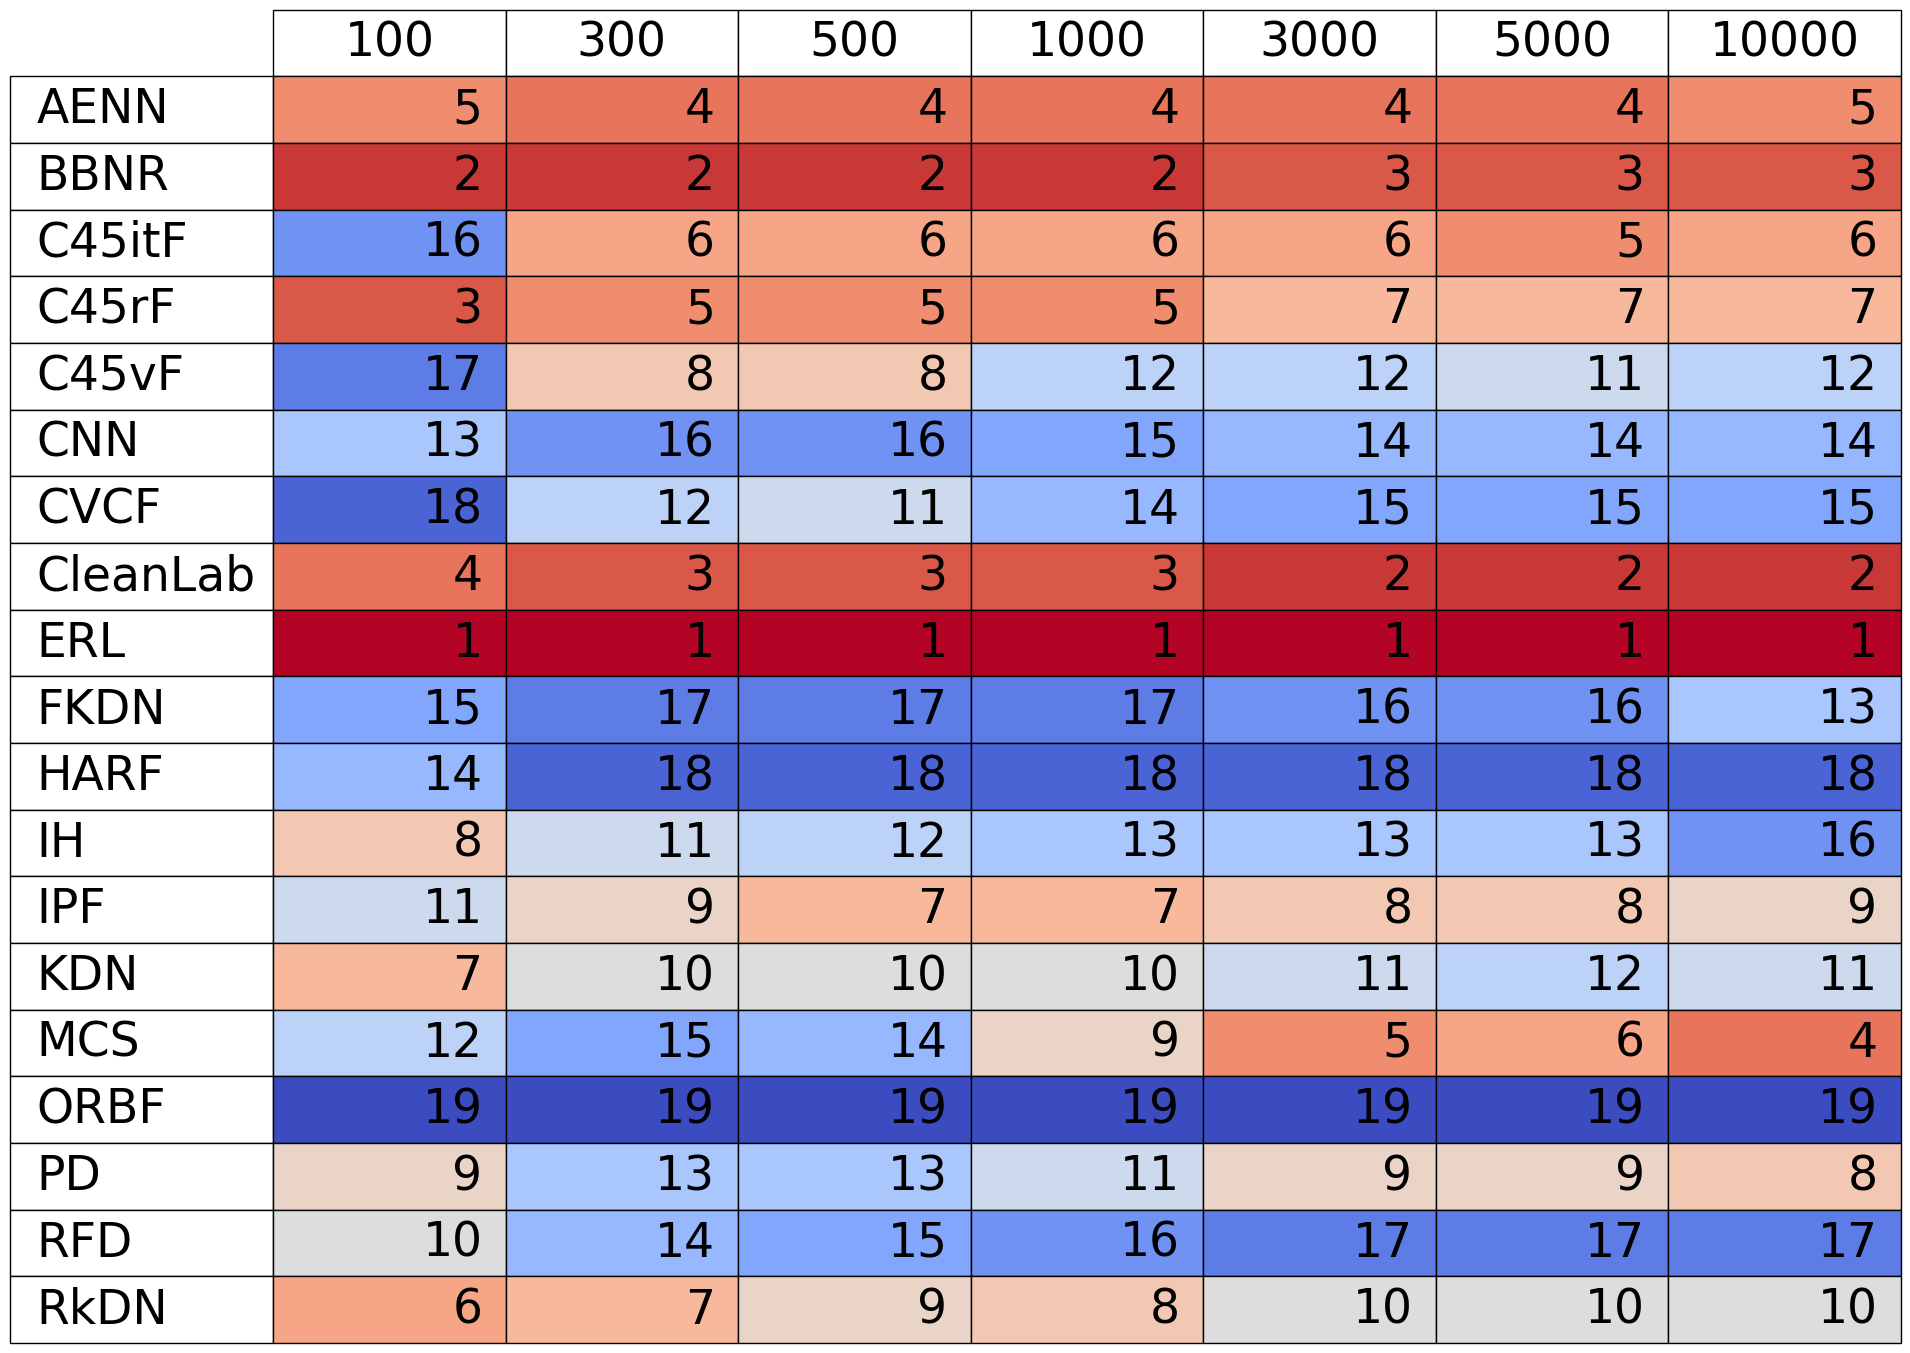

IndexError: list index out of range

In [25]:
from matplotlib import pyplot as plt
import numpy as np
randn = np.random.randn
from pandas import *


cols = [0.05, 0.1, 0.2, 0.3, 0.4,  0.5, 0.6, 0.7]
#cols = datasets
Score = pon
variable = 'NoiseLevel'
scores, variabels = [['Precision',pon, 'Recall'],['NoiseLevel','NoiseLevel','NoiseLevel']]

for i, Score in enumerate(scores):
    variable = variables[i]

    df = allScores.pivot_table(values=Score, index='Model', columns=variable, aggfunc='mean')
    df = df.rank(ascending = False)
    #df.columns = cols
    df= df.astype(float).round(4)
    df= df.astype(int)

    vals = df.values# np.around(df.values,4)
    Min=vals.astype(float).min().min()
    Max=vals.astype(float).max().max()
    norm = plt.Normalize(Min-1, Max+1)
    #norm = plt.Normalize(0, 1)
    cmap = plt.get_cmap('coolwarm_r')

    colours = cmap(norm(vals))

    colores = np.zeros((vals.shape[0], vals.shape[1], 4))
    #cmap = plt.get_cmap('viridis')
    #cmap = plt.get_cmap('hot')

    for i in range(vals.shape[1]):
        col_data = pd.Series(vals[:, i])
        #normal = plt.Normalize(np.min(col_data), np.max(col_data))
        #colores[:, i]  = cmap(norm(col_data))
        a = ((col_data -col_data.min())/(col_data.max() - col_data.min())).to_numpy()
        a = np.ma.masked_array(a)
        colores[:, i] = cmap(a)


    fig = plt.figure(figsize=(15,8))
    ax = fig.add_subplot(111, frameon=False, xticks=[], yticks=[])

    ytable=plt.table(cellText=vals, rowLabels=df.index, colLabels=df.columns, 
                        colWidths = [0.2]*vals.shape[1]
                      #  colHeights = [0.2]*vals.shape[0]
                        , loc='center', 
                        cellColours=colores)
    ytable.set_fontsize(34)
    ytable.scale(1, 4)
    plt.savefig('figures/ModelvsDataset'+Score+'.png',transparent=False,bbox_inches = 'tight'                   )

    plt.show()


In [ ]:
#dfs.groupby(['Group','Model']).mean()#.sort_values('Precision')

#### Pivot table (heatmap) of  model performance vs. all averaged scores

In [ ]:
import matplotlib.cm as cm
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

#fig = plt.figure(figsize=(15,8))
#a = dfs[dfs['DatasetSize']==10000]
a = dfs
means = a.groupby('Model').mean().sort_values(pon, ascending = False)
means
fig, ax = plt.subplots(figsize=(28,4))

columns=['Execution Time','Precision',pon,'Recall','F-score', 'PLR-Inv']

conf_data = means[columns].round(3).to_numpy()

#conf_data = pd.DataFrame(conf_data)#.sort_values(4, ascending = False).to_numpy()
conf_data = pd.DataFrame(conf_data).to_numpy()

colores = np.zeros((conf_data.shape[0], conf_data.shape[1], 4))
cmap = plt.get_cmap('viridis')

cmap = plt.get_cmap('Reds').reversed()

for i in range(conf_data.shape[1]):
    
    col_data = pd.Series(conf_data[:, i])
    normal = plt.Normalize(np.min(col_data), np.max(col_data))
    #colores[:, i]  = cmap(norm(col_data))
    a = ((col_data -col_data.min())/(col_data.max() - col_data.min())).to_numpy()
    a = np.ma.masked_array(a)
    if i in  [0,len(columns)-1]:
        colores[:, i] =  cmap.reversed()(a)
    else:
        colores[:, i] = cmap(a)


#col_data = pd.Series(conf_data[:, 0])
#a = ((col_data -col_data.min())/(col_data.max() - col_data.min())).to_numpy()
#colores[:, 0] = cmap(a)

rows = means.index.to_list()

ax.axis('off')
ax.axis('tight')
conf_data = [['%.3f' % j for j in i] for i in conf_data]
table = ax.table(cellText=conf_data#.round(3)
                 ,
         rowLabels=rows,
         colLabels=columns,
         cellColours=colores,
         loc='center',
         colWidths=[0.2]*len(columns),
        )
table.set_fontsize(34)
table.scale(1, 4)
fig.tight_layout()
plt.savefig('figures/heatmap_table_means_over_everything'+b+'.png',transparent=False,bbox_inches = 'tight'                   )

plt.show()